In [1]:
import numpy as np
from scipy import stats
from sklearn.metrics import r2_score,cohen_kappa_score,balanced_accuracy_score,median_absolute_error
from collections import defaultdict

%load_ext sql
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
plt.rcParams['font.size'] = '16'



# Preliminary investigations

What types are assigned pchembl_values?

In [2]:
%sql postgresql://ccg_read@scotland/chembl_32 \
select standard_type,count(molregno) from activities where pchembl_value is not null \
group by (standard_type)


11 rows affected.


[('AC50', 89408),
 ('EC50', 314655),
 ('IC50', 1724810),
 ('% inhibition', 766),
 ('Inhibition', 56),
 ('Kd', 64641),
 ('Ki', 476329),
 ('log(43000/Ki)', 259),
 ('pIC50', 1),
 ('Potency', 1265974),
 ('XC50', 13450)]

How many IC50 assays are there for some common targets?

In [3]:
# human BRD4
%sql select count(distinct(assay_id)) from activities \
 join assays using (assay_id) \
 join target_dictionary using (tid) where standard_type='IC50' and target_type='SINGLE PROTEIN' \
  and target_dictionary.chembl_id='CHEMBL1163125';


 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.


[(454,)]

In [4]:
# human CDK2
%sql select count(distinct(assay_id)) from activities \
 join assays using (assay_id) \
 join target_dictionary using (tid) where standard_type='IC50' and target_type='SINGLE PROTEIN' \
  and target_dictionary.chembl_id='CHEMBL301';


 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.


[(343,)]

In [5]:
# human CDK2
%sql select count(distinct(assay_id)) from activities \
 join assays using (assay_id) \
 join target_dictionary using (tid) where standard_type='IC50' and target_type='SINGLE PROTEIN' \
  and target_dictionary.chembl_id='CHEMBL240';


 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.


[(2020,)]

How many assay pairs are there?

In [17]:
%sql drop table if exists ic50_assays

%sql select distinct(assay_id) into temporary table ic50_assays from activities \
 join assays using (assay_id) \
 join target_dictionary using (tid) where standard_type='IC50' and target_type='SINGLE PROTEIN';

%sql select count(*) from \
 (select assays.* from assays join ic50_assays using (assay_id)) a1 \
cross join \
 (select assays.* from assays join ic50_assays using (assay_id)) a2 \
where a1.assay_id > a2.assay_id \
        and a1.tid = a2.tid \
        and a1.assay_type = a2.assay_type \
        and a1.assay_organism is not distinct from a2.assay_organism \
        and a1.assay_category is not distinct from a2.assay_category \
        and a1.assay_tax_id is not distinct from a2.assay_tax_id \
        and a1.assay_strain is not distinct from a2.assay_strain \
        and a1.assay_tissue is not distinct from a2.assay_tissue \
        and a1.assay_cell_type is not distinct from a2.assay_cell_type \
        and a1.assay_subcellular_fraction is not distinct from a2.assay_subcellular_fraction \
        and a1.bao_format is not distinct from a2.bao_format;


 * postgresql://ccg_read@scotland/chembl_32
Done.
 * postgresql://ccg_read@scotland/chembl_32
109989 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.


[(5143596,)]

How many of those are in the same document?

In [23]:
%sql drop table if exists ic50_assays

%sql select distinct(assay_id) into temporary table ic50_assays from activities \
 join assays using (assay_id) \
 join target_dictionary using (tid) where standard_type='IC50' and target_type='SINGLE PROTEIN';

%sql select count(*) from \
 (select assays.* from assays join ic50_assays using (assay_id)) a1 \
cross join \
 (select assays.* from assays join ic50_assays using (assay_id)) a2 \
where a1.assay_id > a2.assay_id \
        and a1.tid = a2.tid \
        and a1.doc_id = a2.doc_id \
        and a1.assay_type = a2.assay_type \
        and a1.assay_organism is not distinct from a2.assay_organism \
        and a1.assay_category is not distinct from a2.assay_category \
        and a1.assay_tax_id is not distinct from a2.assay_tax_id \
        and a1.assay_strain is not distinct from a2.assay_strain \
        and a1.assay_tissue is not distinct from a2.assay_tissue \
        and a1.assay_cell_type is not distinct from a2.assay_cell_type \
        and a1.assay_subcellular_fraction is not distinct from a2.assay_subcellular_fraction \
        and a1.bao_format is not distinct from a2.bao_format;


 * postgresql://ccg_read@scotland/chembl_32
Done.
 * postgresql://ccg_read@scotland/chembl_32
109989 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.


[(57654,)]

In [18]:
%sql select count(*) from ic50_assays;

 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.


[(109989,)]

In [22]:
%sql select targets.chembl_id,count(distinct(assay_id)) assay_count,targets.pref_name from ic50_assays \
join assays using (assay_id) \
join target_dictionary targets using (tid) \
join activities using (assay_id) \
group by (tid,targets.chembl_id,targets.pref_name) order by assay_count desc limit 10 ;

 * postgresql://ccg_read@scotland/chembl_32
10 rows affected.


[('CHEMBL340', 2225, 'Cytochrome P450 3A4'),
 ('CHEMBL240', 2020, 'HERG'),
 ('CHEMBL289', 1554, 'Cytochrome P450 2D6'),
 ('CHEMBL203', 1511, 'Epidermal growth factor receptor erbB1'),
 ('CHEMBL3397', 1507, 'Cytochrome P450 2C9'),
 ('CHEMBL3356', 1121, 'Cytochrome P450 1A2'),
 ('CHEMBL3622', 1061, 'Cytochrome P450 2C19'),
 ('CHEMBL279', 1030, 'Vascular endothelial growth factor receptor 2'),
 ('CHEMBL247', 859, 'Human immunodeficiency virus type 1 reverse transcriptase'),
 ('CHEMBL220', 753, 'Acetylcholinesterase')]

# The data gathering and analysis

In [2]:
def gather_data(standard_type,maxMatch=True,includeAssayType=True,
                minOverlap=5,minAssaySize=20,maxAssaySize=100,
                includeActivityCuration=True,onlyDocs=True,removeMutants=True,noDuplicateDocs=True,
                onlyHighConfidence=True):
    # password is stored in ~/.pgpass, so we don't need to worry about it here
    connection_string = f"postgresql://ccg_read@scotland/chembl_32"

    %config SqlMagic.feedback = False

    %sql $connection_string \
        drop table if exists temp_assays

    if standard_type in ('Ki','IC50'):
        %sql \
        select assay_id,assays.chembl_id assay_chembl_id,description,tid,targets.chembl_id target_chembl_id,\
                  count(distinct(molregno)) cnt,pref_name,assays.doc_id doc_id,docs.year doc_date \
                into temporary table temp_assays  \
                from activities  \
                join assays using(assay_id)  \
                join docs on (assays.doc_id = docs.doc_id)  \
                join target_dictionary as targets using (tid) \
                where pchembl_value is not null   \
                and standard_type=:standard_type \
                and standard_units = 'nM'  \
                and data_validity_comment is null  \
                and standard_relation = '=' \
                and target_type = 'SINGLE PROTEIN' \
                group by (assay_id,assays.chembl_id,description,tid,targets.chembl_id,pref_name,\
                          assays.doc_id,docs.year) \
                order by cnt desc; 
    else:
        %sql \
        select assay_id,assays.chembl_id assay_chembl_id,description,tid,targets.chembl_id target_chembl_id,\
                  count(distinct(molregno)) cnt,pref_name,assays.doc_id doc_id,docs.year doc_date \
                into temporary table temp_assays  \
                from activities  \
                join assays using(assay_id)  \
                join docs on (assays.doc_id = docs.doc_id)  \
                join target_dictionary as targets using (tid) \
                where pchembl_value is not null   \
                and standard_type in ('IC50','AC50','pIC50','XC50','EC50') \
                and standard_units = 'nM'  \
                and data_validity_comment is null  \
                and standard_relation = '=' \
                and target_type = 'SINGLE PROTEIN' \
                group by (assay_id,assays.chembl_id,description,tid,targets.chembl_id,pref_name,\
                          assays.doc_id,docs.year) \
                order by cnt desc; 
                  
    if onlyDocs:
        %sql \
        delete from temp_assays where doc_date is null;

    if removeMutants:
        %sql \
        delete from temp_assays where lower(description) like '%mutant%' or lower(description) like '%recombinant%';       

    if onlyHighConfidence:
        %sql \
          alter table temp_assays rename to temp_assays_1;
        %sql \
          select ta1.* into temporary table temp_assays \
            from temp_assays_1 ta1 join assays using(assay_id) \
            where confidence_score = 9;
        %sql \
           drop table temp_assays_1;

        
    print('goldilocks')
    %sql \
        drop table if exists goldilocks
    %sql \
    select assay_id,tid,molregno,pchembl_value,temp_assays.doc_id,standard_type,activity_id into temporary table goldilocks \
    from activities \
    join temp_assays using (assay_id) \
    where pchembl_value is not null   \
    and standard_units = 'nM'  \
    and data_validity_comment is null  \
    and standard_relation = '=' \
    and cnt>=:minAssaySize and cnt<=:maxAssaySize;

    if standard_type in ('Ki','IC50'):
        %sql \
        delete from goldilocks where standard_type != :standard_type;
    else:
        %sql \
        delete from goldilocks where standard_type not in ('IC50','AC50','pIC50','XC50','EC50');
            
            
    print('goldilocks_ovl')
    %sql \
        drop table if exists goldilocks_ovl
    if includeActivityCuration:
        %sql \
        select c1.tid,c1.assay_id aid1,c2.assay_id aid2,count(distinct c1.molregno) ovl,\
           c1.doc_id doc_id1, c2.doc_id doc_id2 \
        into temporary table goldilocks_ovl \
        from goldilocks c1 cross join goldilocks c2 \
        where c1.assay_id>c2.assay_id and c1.tid=c2.tid  and c1.molregno=c2.molregno \
        and c1.pchembl_value != c2.pchembl_value \
        and abs(c1.pchembl_value - c2.pchembl_value)!=3.0 \
        group by (c1.tid,c1.assay_id,c2.assay_id,c1.doc_id,c2.doc_id) order by ovl desc;
    else:
        %sql \
        select c1.tid,c1.assay_id aid1,c2.assay_id aid2,count(distinct c1.molregno) ovl, \
           c1.doc_id doc_id1, c2.doc_id doc_id2 \
        into temporary table goldilocks_ovl \
        from goldilocks c1 cross join goldilocks c2 \
        where c1.assay_id>c2.assay_id and c1.tid=c2.tid  and c1.molregno=c2.molregno \
        group by (c1.tid,c1.assay_id,c2.assay_id,c1.doc_id,c2.doc_id) order by ovl desc;

    if noDuplicateDocs:
        %sql \
        delete from goldilocks_ovl where doc_id1=doc_id2;


    print('goldilocks_ovl2')
    %sql \
        drop table if exists goldilocks_ovl2
    %sql \
    select ovl.*,count(distinct a1.molregno) a1cnt,count(distinct a2.molregno) a2cnt \
    into temporary table goldilocks_ovl2 \
    from goldilocks_ovl ovl \
      join goldilocks a1 on (aid1=a1.assay_id) join goldilocks a2 on (aid2=a2.assay_id)  \
    where ovl>:minOverlap \
        group by (ovl.tid,ovl.aid1,ovl.aid2,ovl.ovl,ovl.doc_id1,ovl.doc_id2);

    print('goldilocks_ovl3')
    %sql \
        drop table if exists goldilocks_ovl3
    %sql \
    select lu3.chembl_id target_chembl_id,lu1.chembl_id assay1_chembl_id,lu2.chembl_id assay2_chembl_id,ovl,a1cnt,a2cnt,aid1,aid2 \
    into temporary table goldilocks_ovl3 \
    from goldilocks_ovl2 \
    join chembl_id_lookup lu1 on (aid1=lu1.entity_id and lu1.entity_type='ASSAY') \
    join chembl_id_lookup lu2 on (aid2=lu2.entity_id and lu2.entity_type='ASSAY') \
    join chembl_id_lookup lu3 on (tid=lu3.entity_id and lu3.entity_type='TARGET');

    print('get assays')
    if maxMatch:
        d = %sql \
        select ovl3.*,a1.assay_organism a1_s,a2.assay_organism a2_s \
        from goldilocks_ovl3 ovl3 \
        join assays a1 on (assay1_chembl_id=a1.chembl_id) join assays a2 on (assay2_chembl_id=a2.chembl_id) \
        where a1.assay_type = a2.assay_type \
        and a1.assay_organism is not distinct from a2.assay_organism \
        and a1.assay_category is not distinct from a2.assay_category \
        and a1.assay_tax_id is not distinct from a2.assay_tax_id \
        and a1.assay_strain is not distinct from a2.assay_strain \
        and a1.assay_tissue is not distinct from a2.assay_tissue \
        and a1.assay_cell_type is not distinct from a2.assay_cell_type \
        and a1.assay_subcellular_fraction is not distinct from a2.assay_subcellular_fraction \
        and a1.bao_format is not distinct from a2.bao_format \
        order by ovl desc;
    elif includeAssayType:
        d = %sql \
        select ovl3.*,a1.assay_organism a1_s,a2.assay_organism a2_s \
        from goldilocks_ovl3 ovl3 \
        join assays a1 on (assay1_chembl_id=a1.chembl_id) join assays a2 on (assay2_chembl_id=a2.chembl_id) \
        where a1.assay_type = a2.assay_type \
        order by ovl desc;
    else:
        d = %sql \
        select ovl3.*,a1.assay_organism a1_s,a2.assay_organism a2_s \
        from goldilocks_ovl3 ovl3 \
        join assays a1 on (assay1_chembl_id=a1.chembl_id) join assays a2 on (assay2_chembl_id=a2.chembl_id) \
        order by ovl desc;

    print(f'retrieving data for {len(d)} assay pairs')
    pts = []
    for row in d:
        aid1 = row[6]
        aid2 = row[7]
        ad = %sql \
        select a1.molregno,a1.pchembl_value a1_pchembl,a2.pchembl_value a2_pchembl from \
        (select * from goldilocks \
            where assay_id=:aid1 \
        ) a1 \
        join (select * from goldilocks \
            where assay_id=:aid2 \
        ) a2 \
        using (molregno) \
        where a1.standard_type = a2.standard_type;
            
        for row in ad:
            r = list(row)
            r.extend([aid1,aid2])
            pts.append(r)
    return pts

def show_comparison(pts,titl):
    plt.figure(figsize=(12, 12))
    xp = np.array([x[1] for x in pts])
    yp = np.array([x[2] for x in pts])

    plt.subplot(2, 2, 1)
    plt.scatter(xp, yp, alpha=0.2, edgecolors='none')
    plt.plot((4, 11), (4, 11), 'k-')
    plt.plot((4, 11), (3, 10), 'k--')
    plt.plot((4, 11), (5, 12), 'k--')
    plt.plot((4, 11), (3.7, 10.7), 'k-.')
    plt.plot((4, 11), (4.3, 11.3), 'k-.')
    plt.xlabel('assay1 pchembl')
    plt.ylabel('assay2 pchembl')
    plt.title(titl)

    plt.subplot(2, 2, 2)
    plt.hexbin(xp, yp, cmap='Blues', bins='log')
    plt.plot((4, 11), (4, 11), 'k-')
    plt.plot((4, 11), (3, 10), 'k--')
    plt.plot((4, 11), (5, 12), 'k--')
    plt.plot((4, 11), (3.7, 10.7), 'k-.')
    plt.plot((4, 11), (4.3, 11.3), 'k-.')
    plt.xlabel('assay1 pchembl')
    plt.ylabel('assay2 pchembl')

    plt.subplot(2, 2, 3)
    delts = np.abs(xp - yp)
    plt.hist(delts, bins=20)
    plt.xlabel('delta pchembl')

    plt.tight_layout()

    aps = set([(x[-1],x[-2]) for x in pts])
    print(f'{len(aps)} assay pairs.')

    
    r, p = stats.spearmanr(xp, yp)
    r2 = r2_score(xp, yp)
    print(
        f'R2={r2:.2f}, Spearman R={r:.2f} MAE={median_absolute_error(xp,yp):.2f}')

    npts = len(delts)
    frac1 = sum(delts > 0.3) / npts
    frac2 = sum(delts > 1) / npts
    print(
        f'{npts} points. Fraction > 0.3: {frac1:.2f}, fraction > 1.0: {frac2:.2f}')

    bins = [5, 6, 7, 8, 9]
    print(f'Fraction with different classifications:')
    for b in bins:
        x_class = xp > b
        y_class = yp > b
        confusion = [[sum(x_class & y_class),
                      sum(x_class & ~y_class)],
                     [sum(~x_class & y_class),
                      sum(~x_class & ~y_class)]]
        missed = sum((xp - b) * (yp - b) < 0) / npts
        print(
            f'\t bin={b}: {missed:.2f}, kappa={cohen_kappa_score(x_class,y_class):.2f}, balanced={balanced_accuracy_score(x_class,y_class):.2f}'
        )
        print(f'\t {confusion}')    

In [3]:
pts = {}

## Max curation

In [4]:
tag = 'xC50, LO assays, no mismatches, remove dupes and off-by-3'
pts[tag] = gather_data('xC50')

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 23 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://

23 assay pairs.
R2=0.71, Spearman R=0.91 MAE=0.08
465 points. Fraction > 0.3: 0.32, fraction > 1.0: 0.10
Fraction with different classifications:
	 bin=5: 0.01, kappa=0.81, balanced=0.92
	 [[449, 3], [2, 11]]
	 bin=6: 0.05, kappa=0.85, balanced=0.93
	 [[353, 15], [9, 88]]
	 bin=7: 0.05, kappa=0.89, balanced=0.94
	 [[189, 16], [10, 250]]
	 bin=8: 0.11, kappa=0.62, balanced=0.81
	 [[63, 29], [26, 347]]
	 bin=9: 0.05, kappa=0.61, balanced=0.84
	 [[22, 9], [16, 418]]


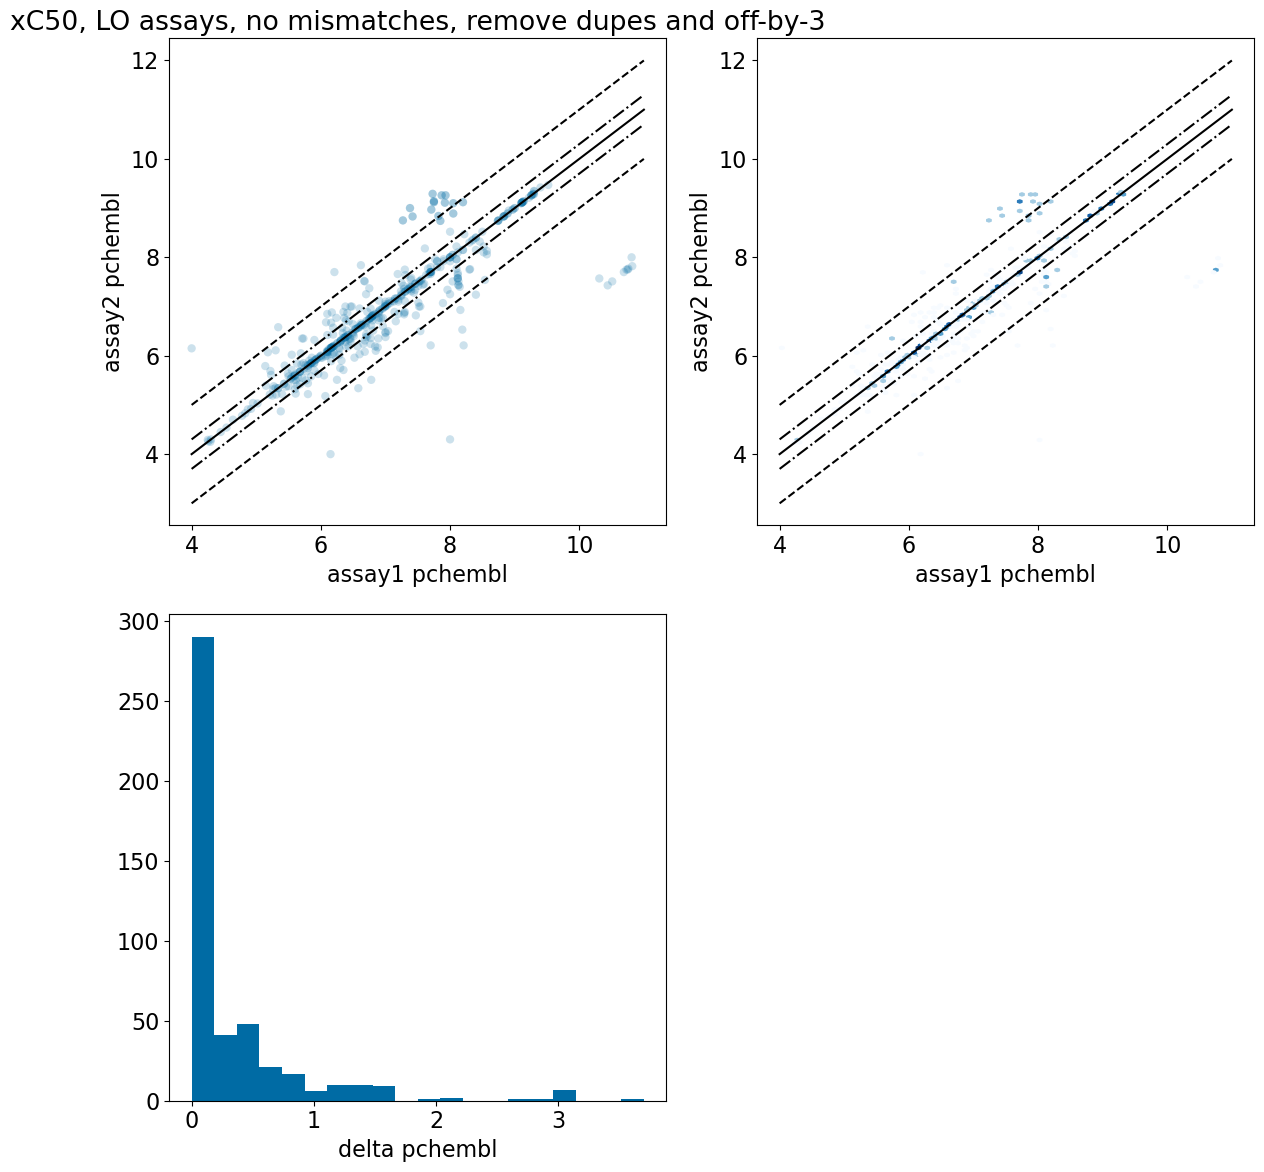

In [5]:
show_comparison(pts[tag],tag)

In [6]:
tag = 'IC50, LO assays, no mismatches, remove dupes and off-by-3'
pts[tag] = gather_data('IC50')

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 19 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://

19 assay pairs.
R2=0.68, Spearman R=0.91 MAE=0.10
391 points. Fraction > 0.3: 0.35, fraction > 1.0: 0.12
Fraction with different classifications:
	 bin=5: 0.01, kappa=0.78, balanced=0.91
	 [[377, 3], [2, 9]]
	 bin=6: 0.06, kappa=0.83, balanced=0.93
	 [[295, 14], [8, 74]]
	 bin=7: 0.04, kappa=0.90, balanced=0.95
	 [[163, 10], [9, 209]]
	 bin=8: 0.12, kappa=0.61, balanced=0.80
	 [[55, 25], [25, 286]]
	 bin=9: 0.06, kappa=0.60, balanced=0.83
	 [[22, 9], [16, 344]]


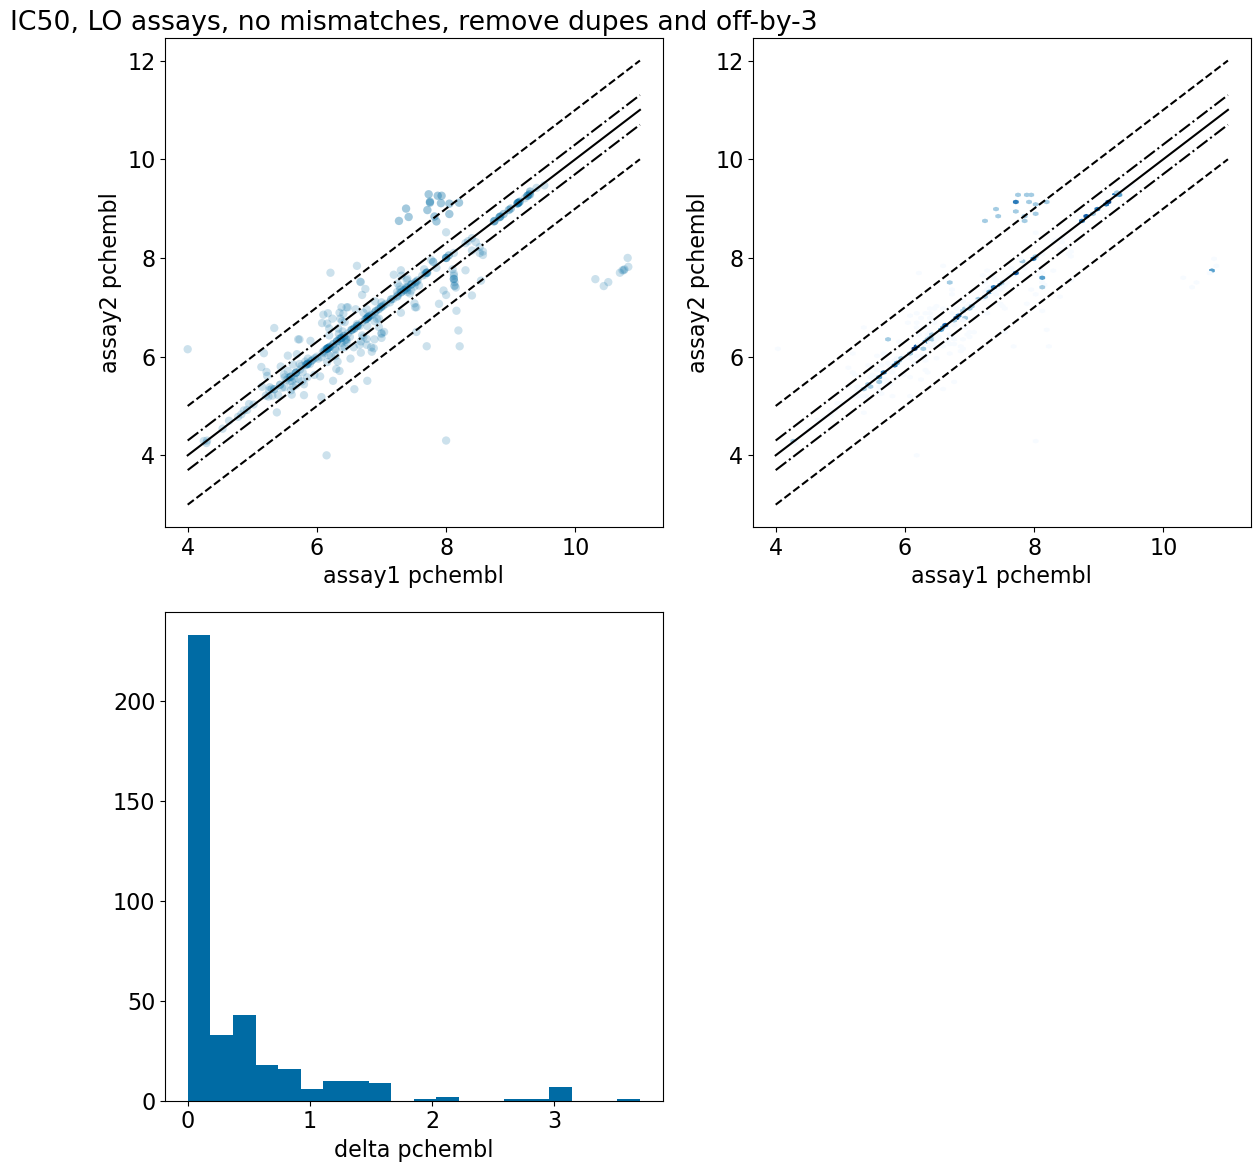

In [7]:
show_comparison(pts[tag],tag)

In [8]:
tag = 'Ki, LO assays, no mismatches, remove dupes and off-by-3'
pts[tag] = gather_data('Ki')

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 55 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://

55 assay pairs.
R2=0.63, Spearman R=0.81 MAE=0.00
1673 points. Fraction > 0.3: 0.24, fraction > 1.0: 0.11
Fraction with different classifications:
	 bin=5: 0.06, kappa=0.70, balanced=0.84
	 [[1423, 45], [59, 146]]
	 bin=6: 0.07, kappa=0.79, balanced=0.90
	 [[1213, 60], [65, 335]]
	 bin=7: 0.13, kappa=0.74, balanced=0.87
	 [[785, 106], [110, 672]]
	 bin=8: 0.06, kappa=0.69, balanced=0.86
	 [[134, 41], [62, 1436]]
	 bin=9: 0.00, kappa=1.00, balanced=1.00
	 [[1, 0], [0, 1672]]


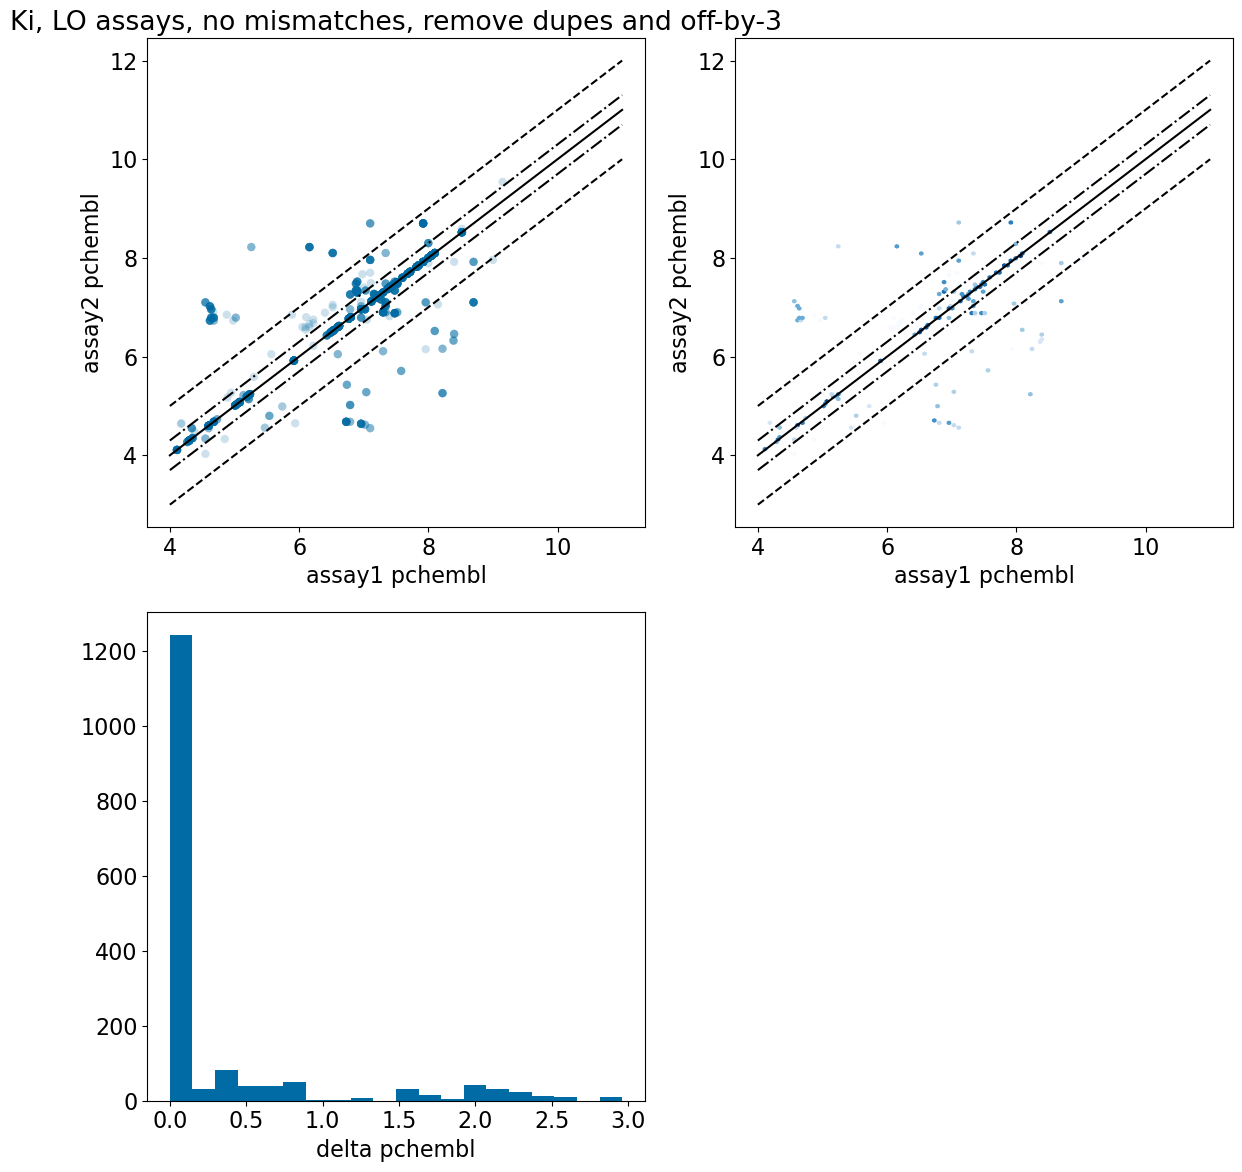

In [9]:
show_comparison(pts[tag],tag)

# Allow large assays

In [10]:
tag = 'xC50 large, no mismatches, remove dupes and off-by-3'
pts[tag] = gather_data('xC50',maxAssaySize=10000)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 35 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://

35 assay pairs.
R2=0.77, Spearman R=0.92 MAE=0.01
830 points. Fraction > 0.3: 0.27, fraction > 1.0: 0.08
Fraction with different classifications:
	 bin=5: 0.01, kappa=0.89, balanced=0.94
	 [[771, 5], [6, 48]]
	 bin=6: 0.03, kappa=0.90, balanced=0.95
	 [[623, 18], [12, 177]]
	 bin=7: 0.06, kappa=0.86, balanced=0.93
	 [[322, 28], [30, 450]]
	 bin=8: 0.07, kappa=0.66, balanced=0.83
	 [[73, 30], [32, 695]]
	 bin=9: 0.03, kappa=0.62, balanced=0.84
	 [[22, 9], [16, 783]]


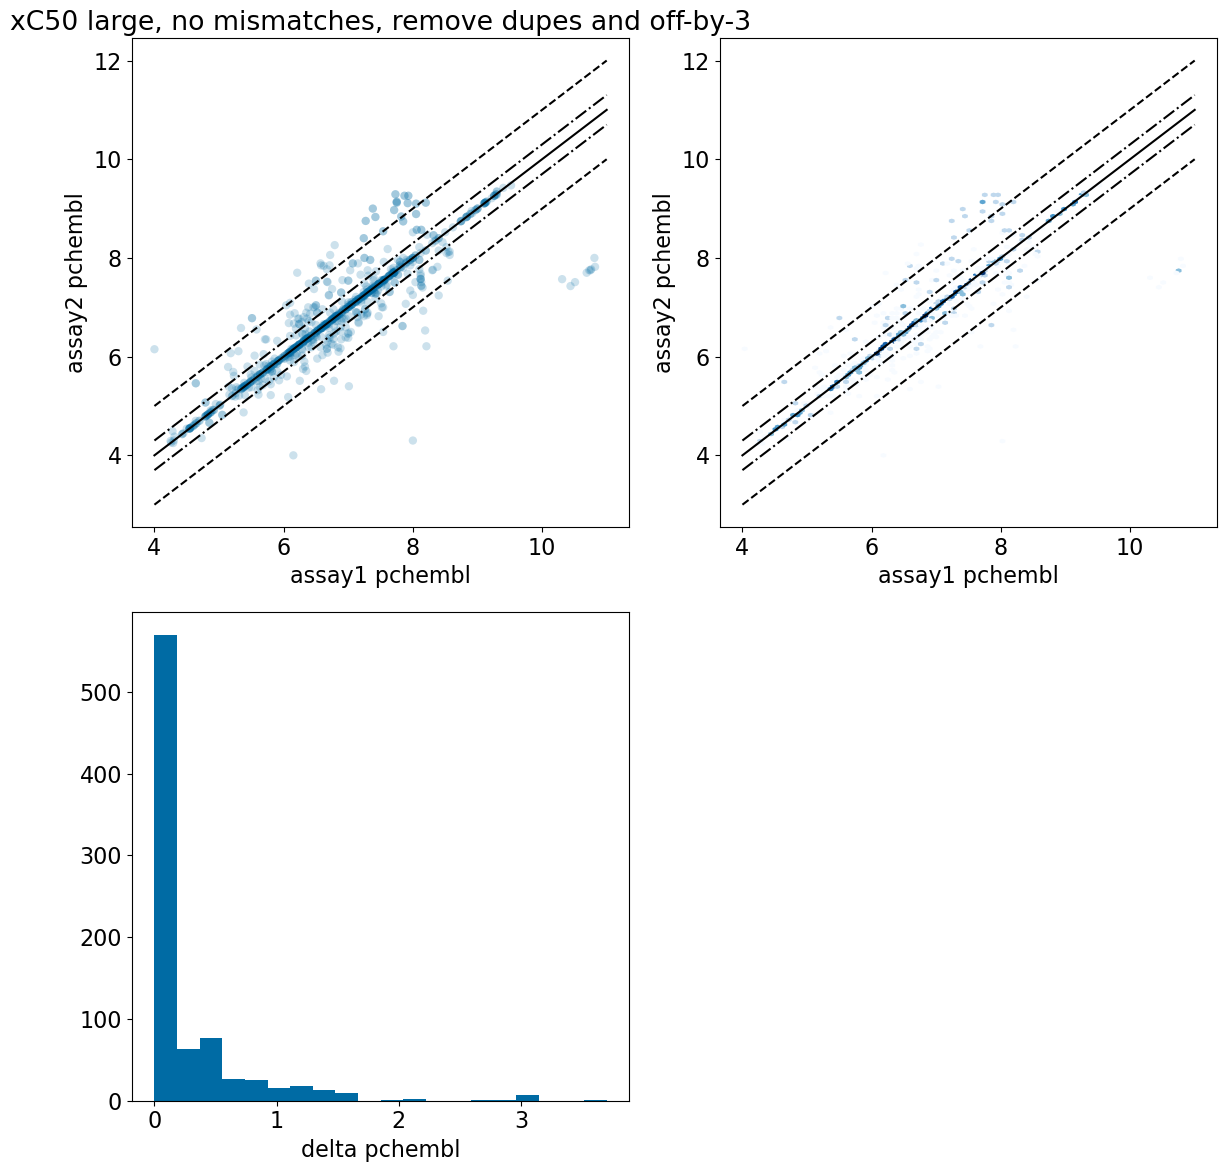

In [11]:
show_comparison(pts[tag],tag)

In [12]:
tag = 'IC50 large, no mismatches, remove dupes and off-by-3'
pts[tag] = gather_data('IC50',maxAssaySize=10000)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 31 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://

31 assay pairs.
R2=0.76, Spearman R=0.92 MAE=0.01
756 points. Fraction > 0.3: 0.27, fraction > 1.0: 0.08
Fraction with different classifications:
	 bin=5: 0.01, kappa=0.89, balanced=0.94
	 [[699, 5], [6, 46]]
	 bin=6: 0.04, kappa=0.90, balanced=0.95
	 [[565, 17], [11, 163]]
	 bin=7: 0.06, kappa=0.86, balanced=0.93
	 [[296, 22], [29, 409]]
	 bin=8: 0.07, kappa=0.65, balanced=0.83
	 [[65, 26], [31, 634]]
	 bin=9: 0.03, kappa=0.62, balanced=0.84
	 [[22, 9], [16, 709]]


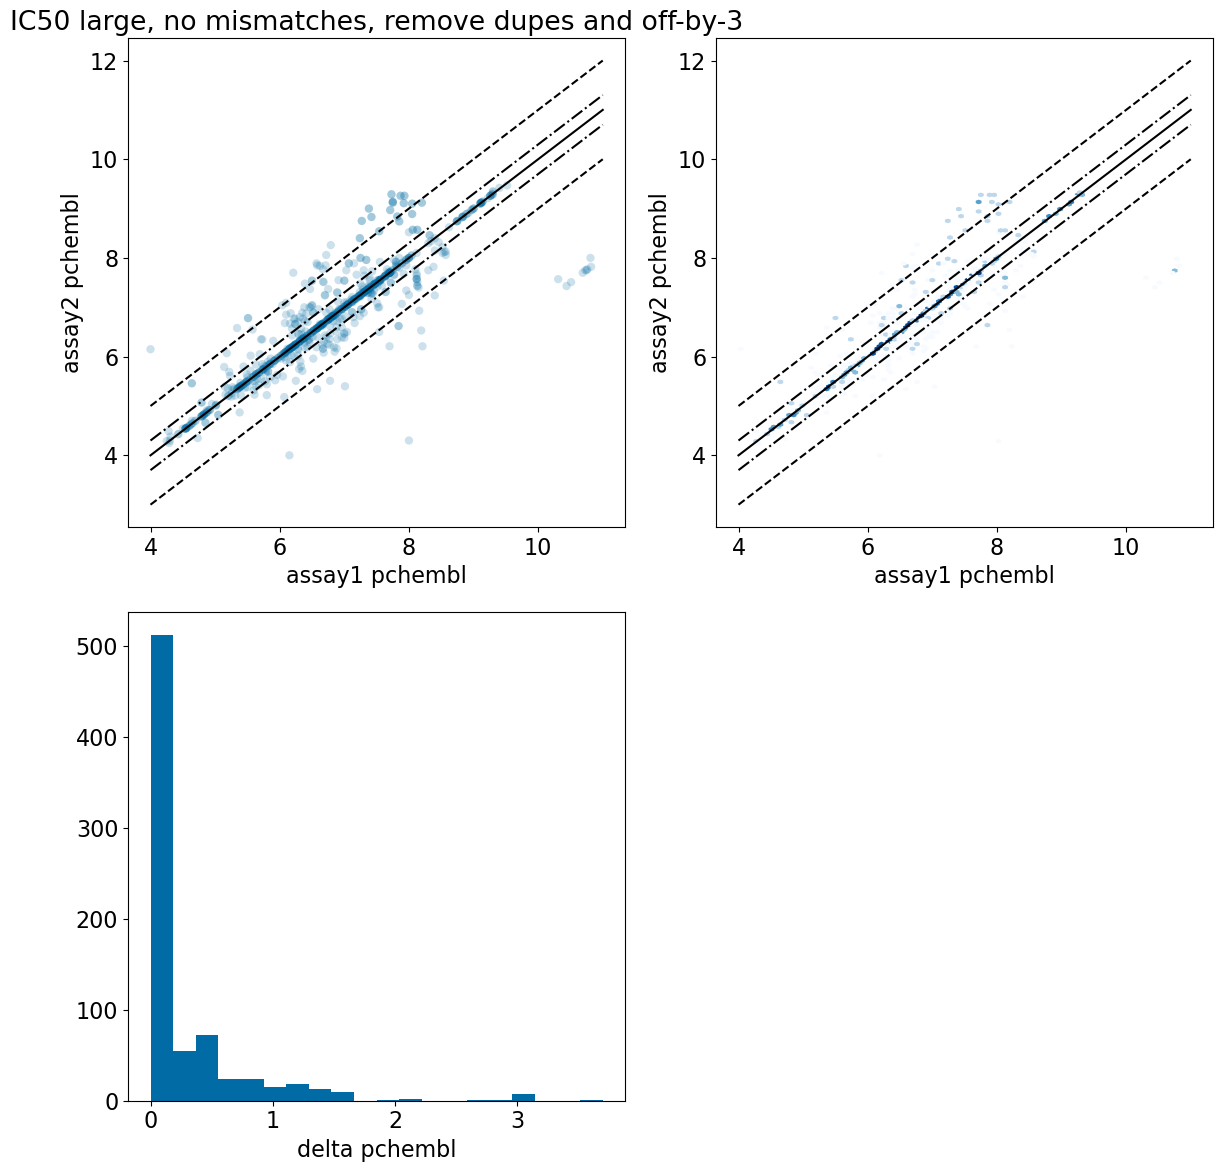

In [13]:
show_comparison(pts[tag],tag)

In [14]:
tag = 'Ki large, no mismatches, remove dupes and off-by-3'
pts[tag] = gather_data('Ki',maxAssaySize=10000)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 60 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://

60 assay pairs.
R2=0.50, Spearman R=0.74 MAE=0.00
1874 points. Fraction > 0.3: 0.26, fraction > 1.0: 0.14
Fraction with different classifications:
	 bin=5: 0.06, kappa=0.70, balanced=0.83
	 [[1615, 45], [65, 149]]
	 bin=6: 0.07, kappa=0.78, balanced=0.88
	 [[1388, 60], [81, 345]]
	 bin=7: 0.15, kappa=0.69, balanced=0.84
	 [[887, 113], [178, 696]]
	 bin=8: 0.09, kappa=0.67, balanced=0.87
	 [[222, 49], [123, 1480]]
	 bin=9: 0.04, kappa=0.58, balanced=0.89
	 [[49, 11], [55, 1759]]


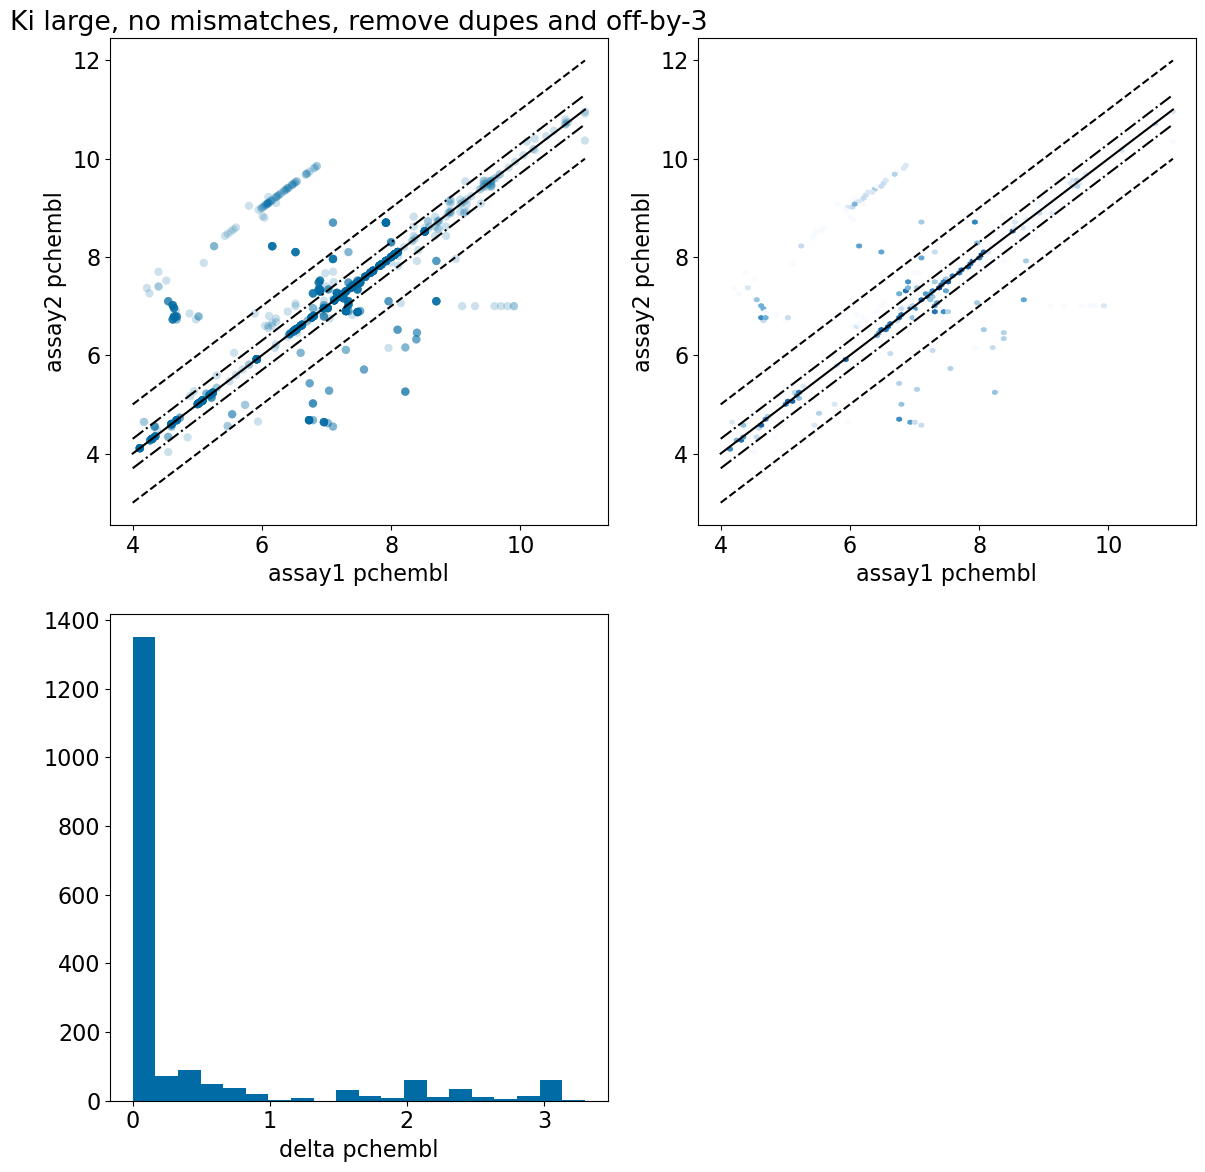

In [15]:
show_comparison(pts[tag],tag)

## Allow doc duplicates

In [16]:
tag = 'xC50, LO assays, no mismatches, remove dupes and off-by-3, dupe docs'
pts[tag] = gather_data('xC50',noDuplicateDocs=False)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 258 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

237 assay pairs.
R2=0.51, Spearman R=0.79 MAE=0.41
7253 points. Fraction > 0.3: 0.60, fraction > 1.0: 0.20
Fraction with different classifications:
	 bin=5: 0.06, kappa=0.66, balanced=0.83
	 [[6192, 261], [236, 564]]
	 bin=6: 0.14, kappa=0.66, balanced=0.83
	 [[4299, 540], [543, 1871]]
	 bin=7: 0.16, kappa=0.63, balanced=0.82
	 [[2178, 521], [738, 3816]]
	 bin=8: 0.14, kappa=0.47, balanced=0.76
	 [[657, 398], [657, 5541]]
	 bin=9: 0.05, kappa=0.27, balanced=0.75
	 [[78, 66], [311, 6798]]


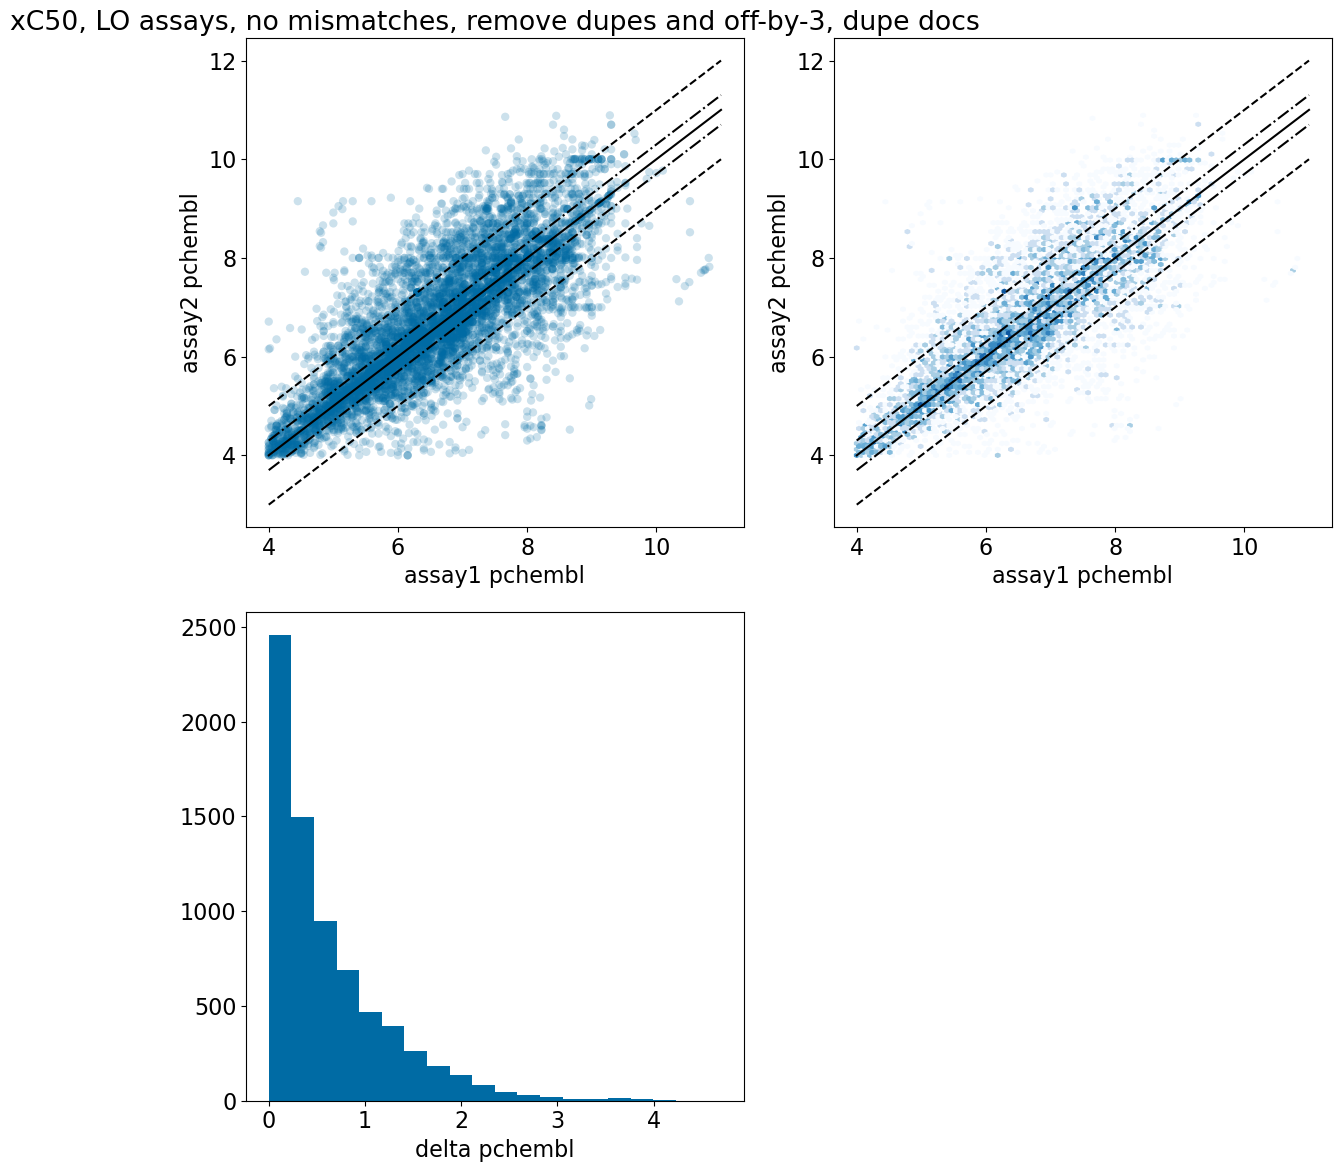

In [17]:
show_comparison(pts[tag],tag)

In [18]:
tag = 'IC50, LO assays, no mismatches, remove dupes and off-by-3, dupe docs'
pts[tag] = gather_data('IC50',noDuplicateDocs=False)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 193 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32


193 assay pairs.
R2=0.50, Spearman R=0.79 MAE=0.41
5943 points. Fraction > 0.3: 0.60, fraction > 1.0: 0.20
Fraction with different classifications:
	 bin=5: 0.06, kappa=0.67, balanced=0.83
	 [[5013, 200], [216, 514]]
	 bin=6: 0.15, kappa=0.64, balanced=0.82
	 [[3390, 475], [486, 1592]]
	 bin=7: 0.16, kappa=0.63, balanced=0.82
	 [[1636, 428], [586, 3293]]
	 bin=8: 0.13, kappa=0.47, balanced=0.76
	 [[498, 321], [491, 4633]]
	 bin=9: 0.05, kappa=0.25, balanced=0.73
	 [[60, 58], [257, 5568]]


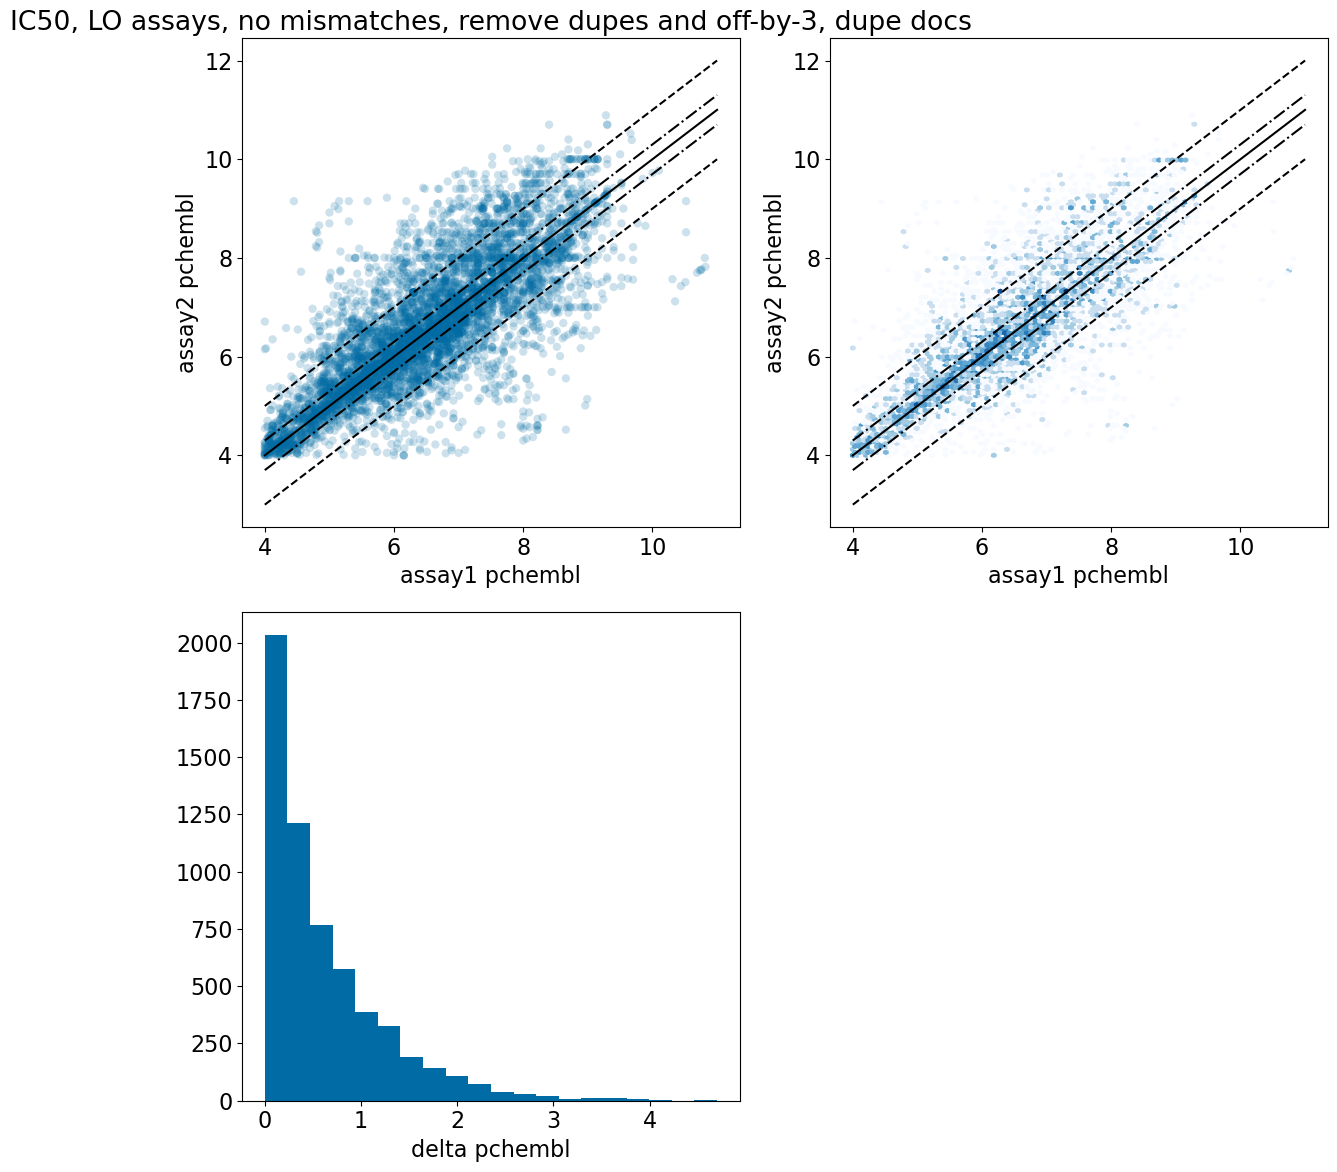

In [19]:
show_comparison(pts[tag],tag)

In [20]:
tag = 'Ki, LO assays, no mismatches, remove dupes and off-by-3, dupe docs'
pts[tag] = gather_data('Ki',noDuplicateDocs=False)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 87 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://

87 assay pairs.
R2=0.63, Spearman R=0.80 MAE=0.05
2538 points. Fraction > 0.3: 0.36, fraction > 1.0: 0.15
Fraction with different classifications:
	 bin=5: 0.06, kappa=0.69, balanced=0.84
	 [[2210, 69], [74, 185]]
	 bin=6: 0.08, kappa=0.77, balanced=0.89
	 [[1847, 109], [97, 485]]
	 bin=7: 0.14, kappa=0.72, balanced=0.86
	 [[1185, 184], [169, 1000]]
	 bin=8: 0.10, kappa=0.66, balanced=0.84
	 [[324, 111], [145, 1958]]
	 bin=9: 0.03, kappa=0.61, balanced=0.88
	 [[68, 18], [64, 2388]]


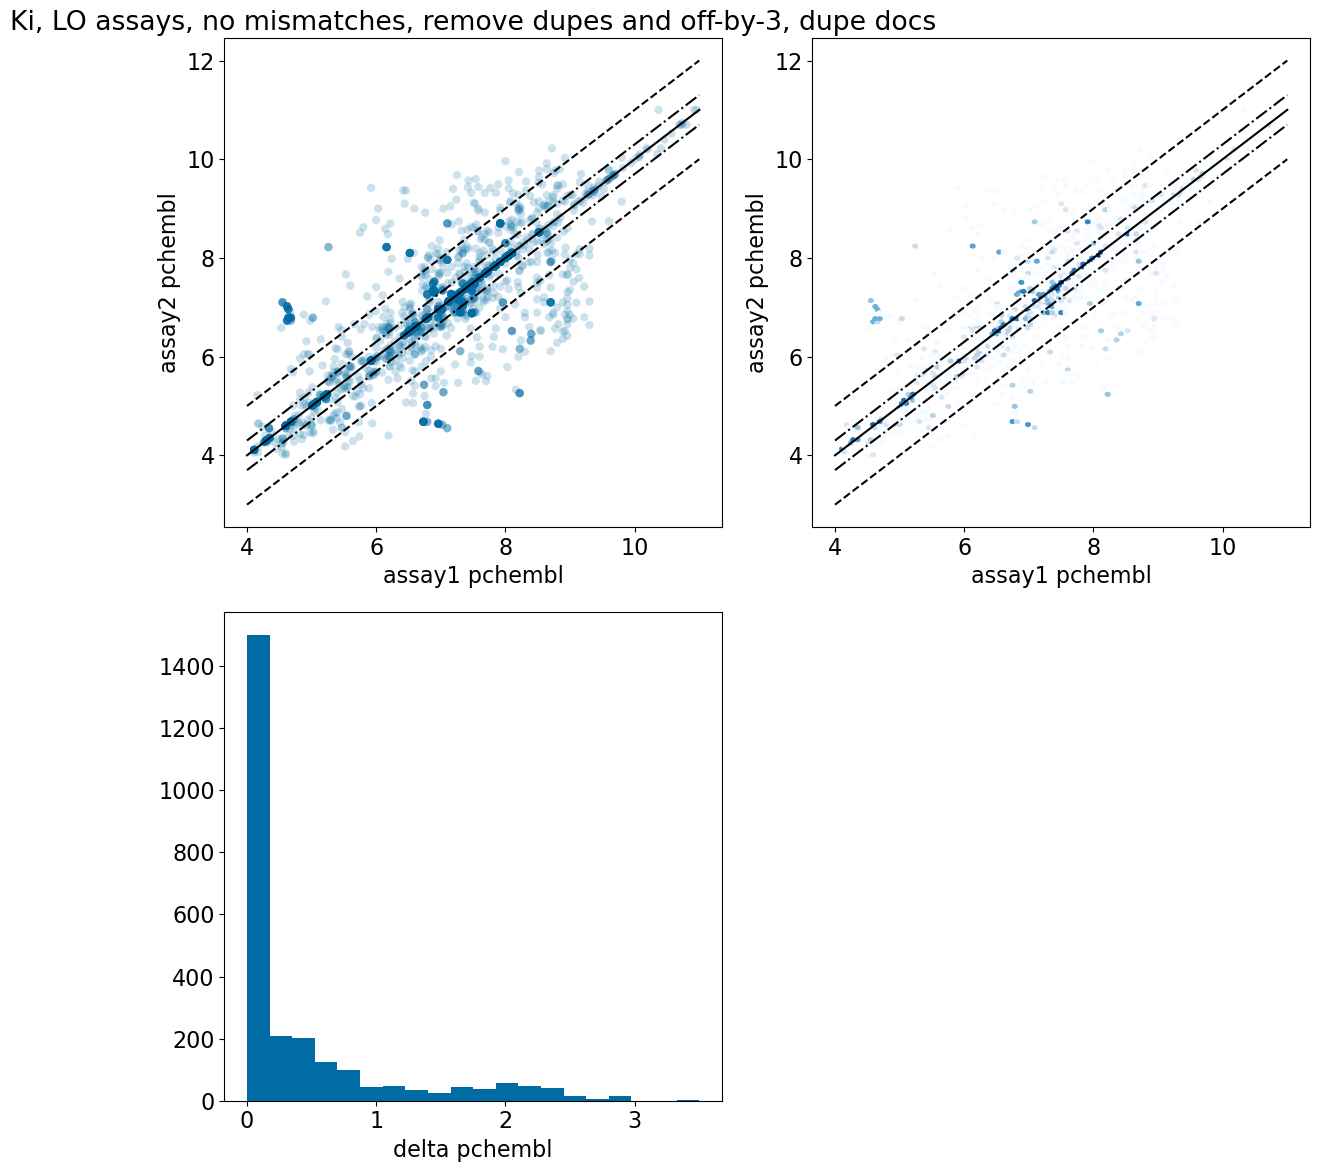

In [21]:
show_comparison(pts[tag],tag)

## Allow mutants and doc duplicates

In [22]:
tag = 'xC50, LO assays, no mismatches, remove dupes and off-by-3, mutants, dupe docs'
pts[tag] = gather_data('xC50',noDuplicateDocs=False,removeMutants=False)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 458 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

433 assay pairs.
R2=0.41, Spearman R=0.73 MAE=0.43
13092 points. Fraction > 0.3: 0.63, fraction > 1.0: 0.22
Fraction with different classifications:
	 bin=5: 0.08, kappa=0.55, balanced=0.77
	 [[11236, 538], [536, 782]]
	 bin=6: 0.17, kappa=0.58, balanced=0.79
	 [[7815, 1155], [1201, 2921]]
	 bin=7: 0.19, kappa=0.59, balanced=0.80
	 [[4088, 1121], [1486, 6397]]
	 bin=8: 0.14, kappa=0.49, balanced=0.76
	 [[1247, 763], [1093, 9989]]
	 bin=9: 0.04, kappa=0.37, balanced=0.76
	 [[180, 149], [418, 12345]]


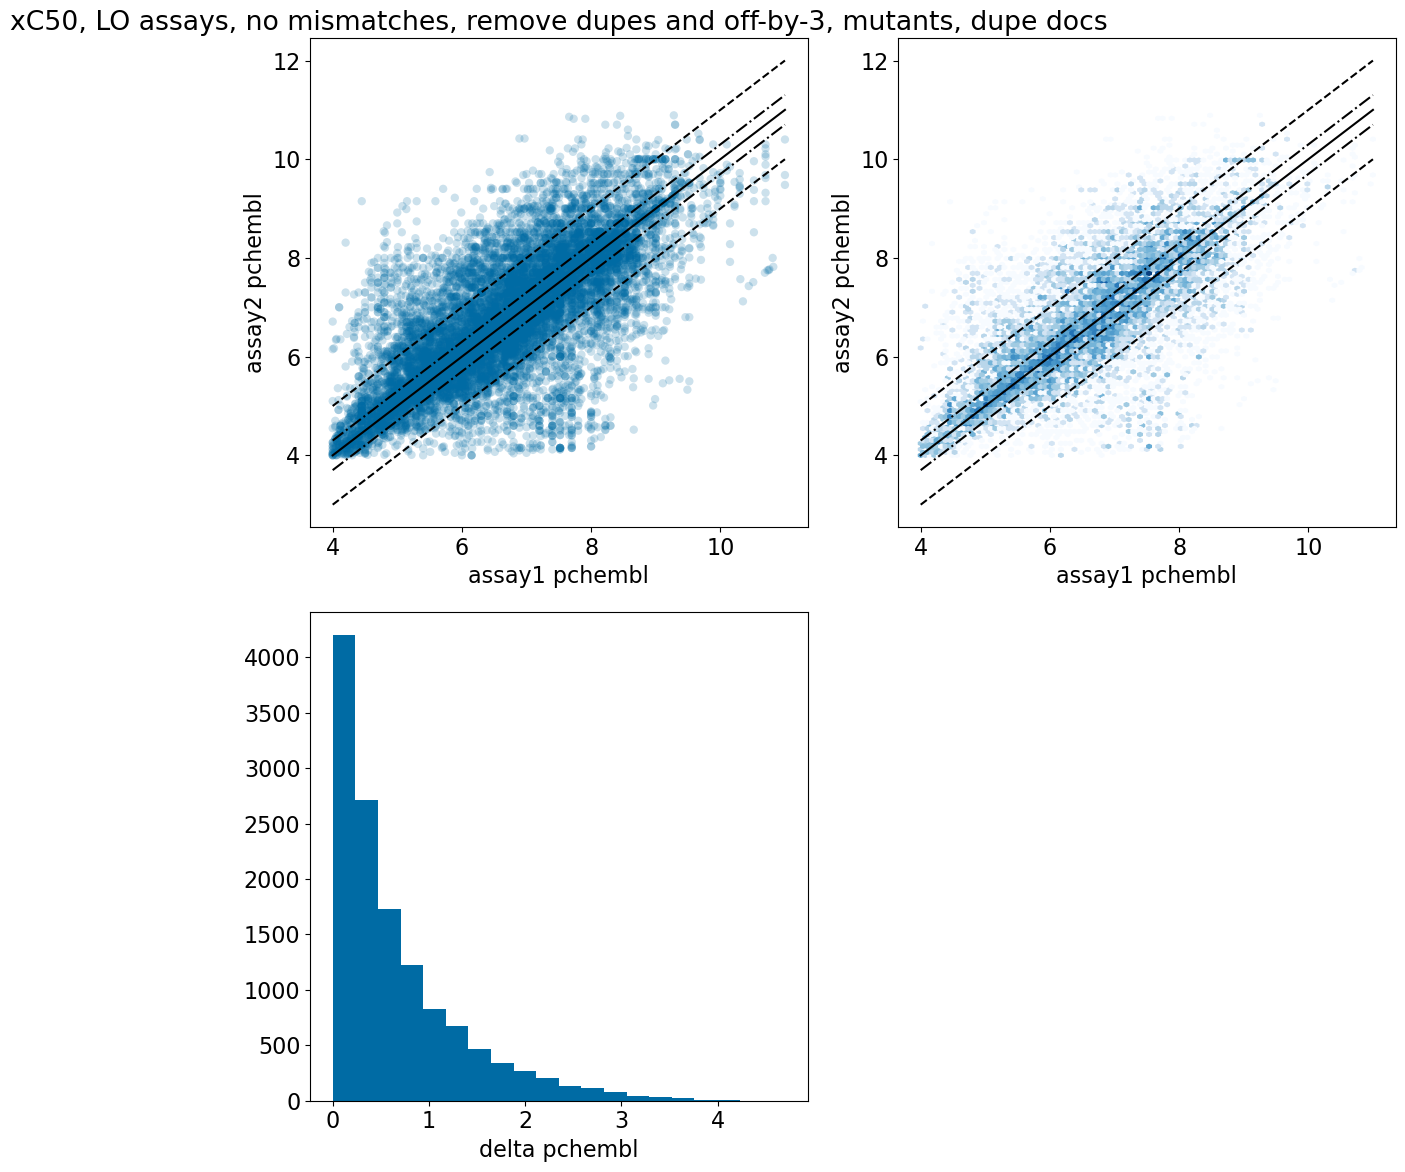

In [23]:
show_comparison(pts[tag],tag)

In [24]:
tag = 'IC50, LO assays, no mismatches, remove dupes and off-by-3, mutants, dupe docs'
pts[tag] = gather_data('IC50',noDuplicateDocs=False,removeMutants=False)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 342 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

342 assay pairs.
R2=0.43, Spearman R=0.72 MAE=0.44
10062 points. Fraction > 0.3: 0.62, fraction > 1.0: 0.23
Fraction with different classifications:
	 bin=5: 0.07, kappa=0.54, balanced=0.76
	 [[8687, 342], [462, 571]]
	 bin=6: 0.19, kappa=0.56, balanced=0.78
	 [[5790, 896], [1039, 2337]]
	 bin=7: 0.18, kappa=0.60, balanced=0.80
	 [[2896, 818], [1099, 5249]]
	 bin=8: 0.13, kappa=0.48, balanced=0.75
	 [[923, 609], [805, 7725]]
	 bin=9: 0.05, kappa=0.38, balanced=0.76
	 [[162, 134], [345, 9421]]


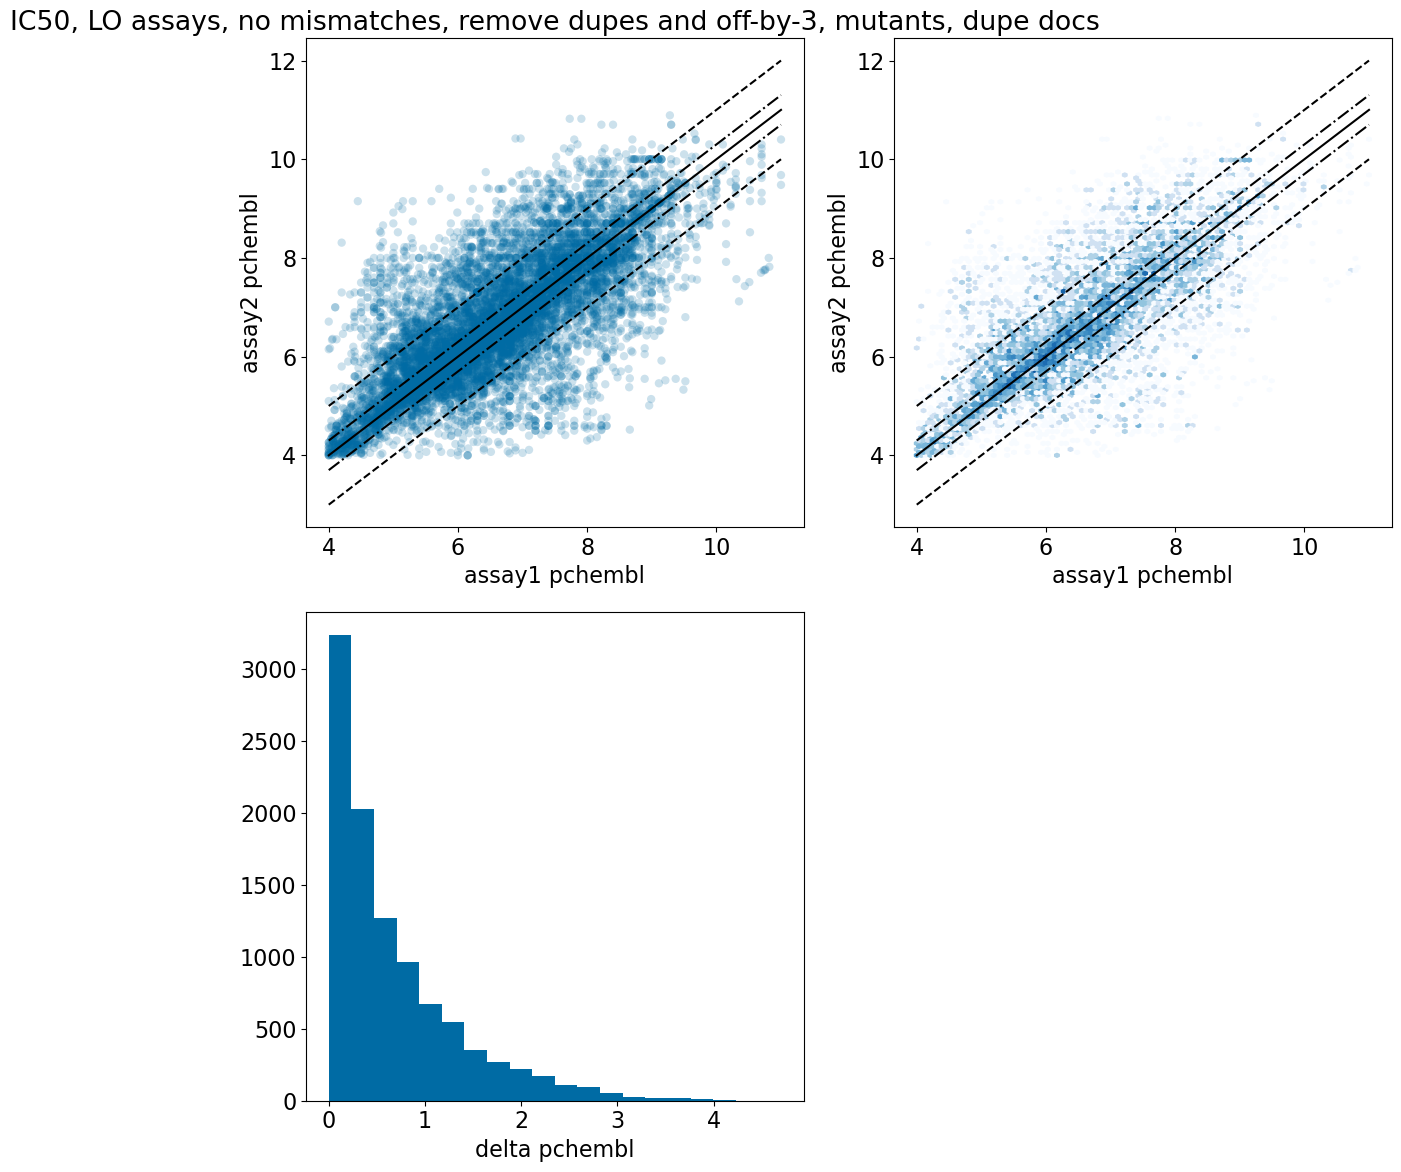

In [25]:
show_comparison(pts[tag],tag)

In [26]:
tag = 'Ki, LO assays, no mismatches, remove dupes and off-by-3, mutants, dupe docs'
pts[tag] = gather_data('Ki',noDuplicateDocs=False,removeMutants=False)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 330 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

330 assay pairs.
R2=0.68, Spearman R=0.83 MAE=0.00
9631 points. Fraction > 0.3: 0.26, fraction > 1.0: 0.11
Fraction with different classifications:
	 bin=5: 0.06, kappa=0.74, balanced=0.87
	 [[8078, 278], [286, 989]]
	 bin=6: 0.07, kappa=0.82, balanced=0.91
	 [[6644, 378], [314, 2295]]
	 bin=7: 0.13, kappa=0.74, balanced=0.87
	 [[4121, 575], [665, 4270]]
	 bin=8: 0.07, kappa=0.69, balanced=0.86
	 [[863, 250], [394, 8124]]
	 bin=9: 0.01, kappa=0.66, balanced=0.90
	 [[93, 22], [70, 9446]]


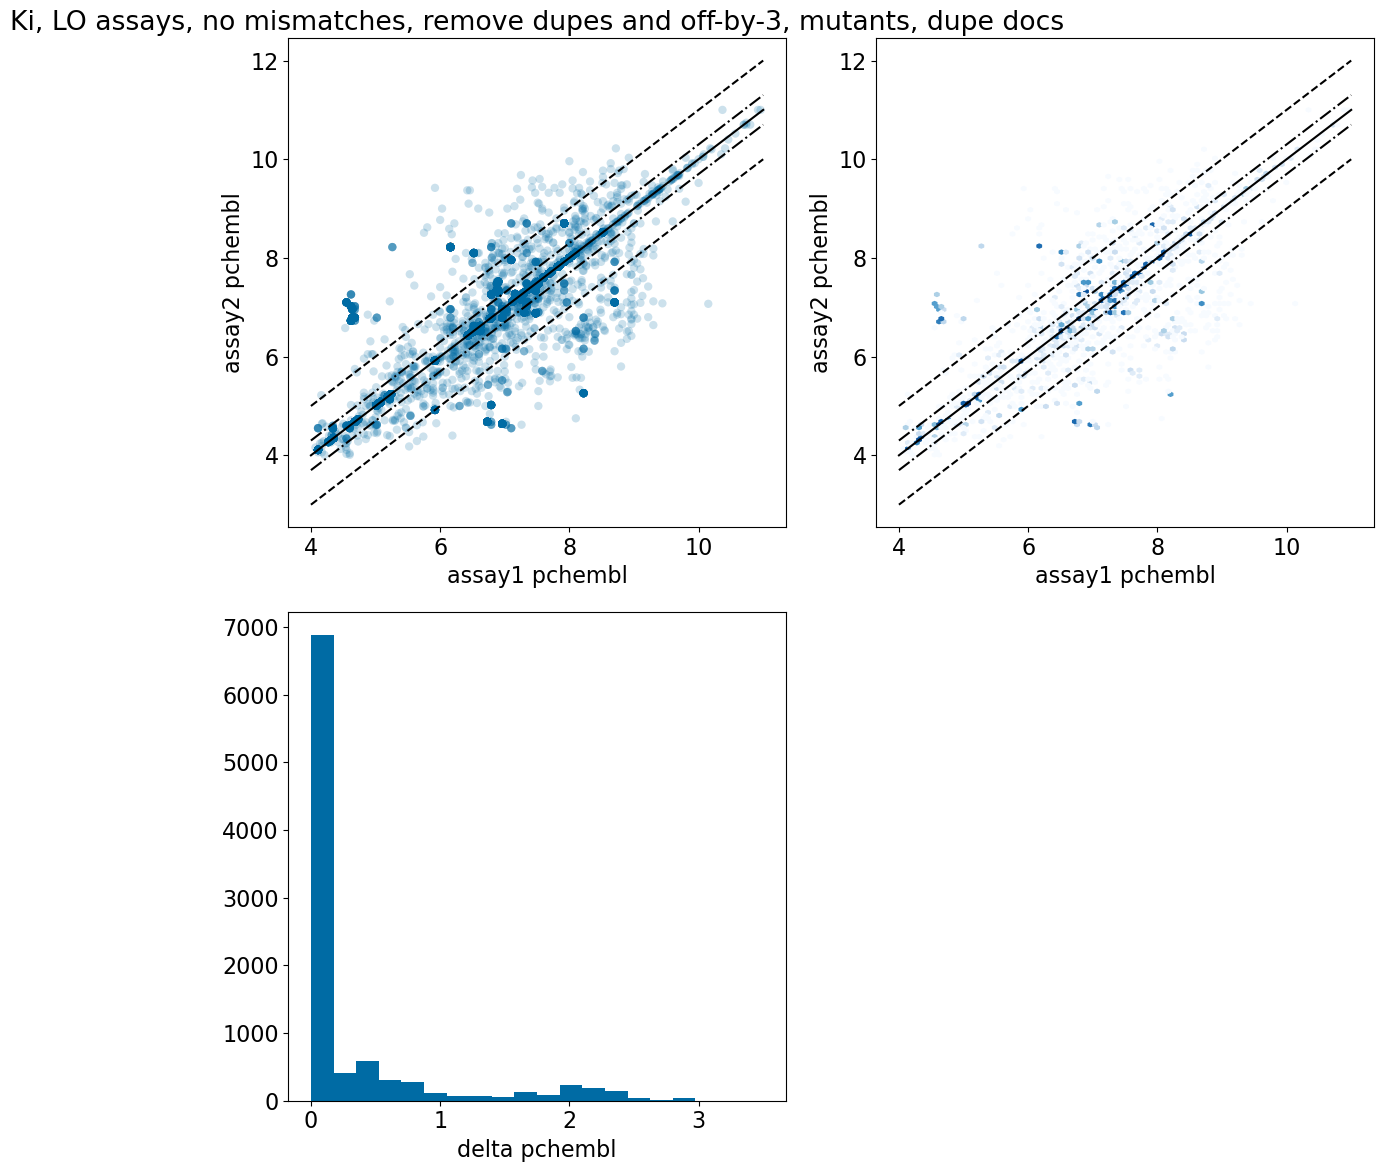

In [27]:
show_comparison(pts[tag],tag)

# Worst case: drop  curation steps

In [30]:
tag = 'xC50, LO assays, minimal curation'
pts[tag] = gather_data('xC50',noDuplicateDocs=False,removeMutants=False,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=False,
                       onlyDocs=False, onlyHighConfidence=False)

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 2249 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

1334 assay pairs.
R2=0.48, Spearman R=0.74 MAE=0.36
38260 points. Fraction > 0.3: 0.55, fraction > 1.0: 0.22
Fraction with different classifications:
	 bin=5: 0.05, kappa=0.59, balanced=0.78
	 [[34584, 904], [1138, 1634]]
	 bin=6: 0.13, kappa=0.62, balanced=0.80
	 [[26360, 2270], [3092, 6538]]
	 bin=7: 0.20, kappa=0.60, balanced=0.80
	 [[15377, 2677], [5075, 15131]]
	 bin=8: 0.15, kappa=0.58, balanced=0.82
	 [[6104, 1899], [3923, 26334]]
	 bin=9: 0.04, kappa=0.58, balanced=0.82
	 [[1378, 692], [1106, 35084]]


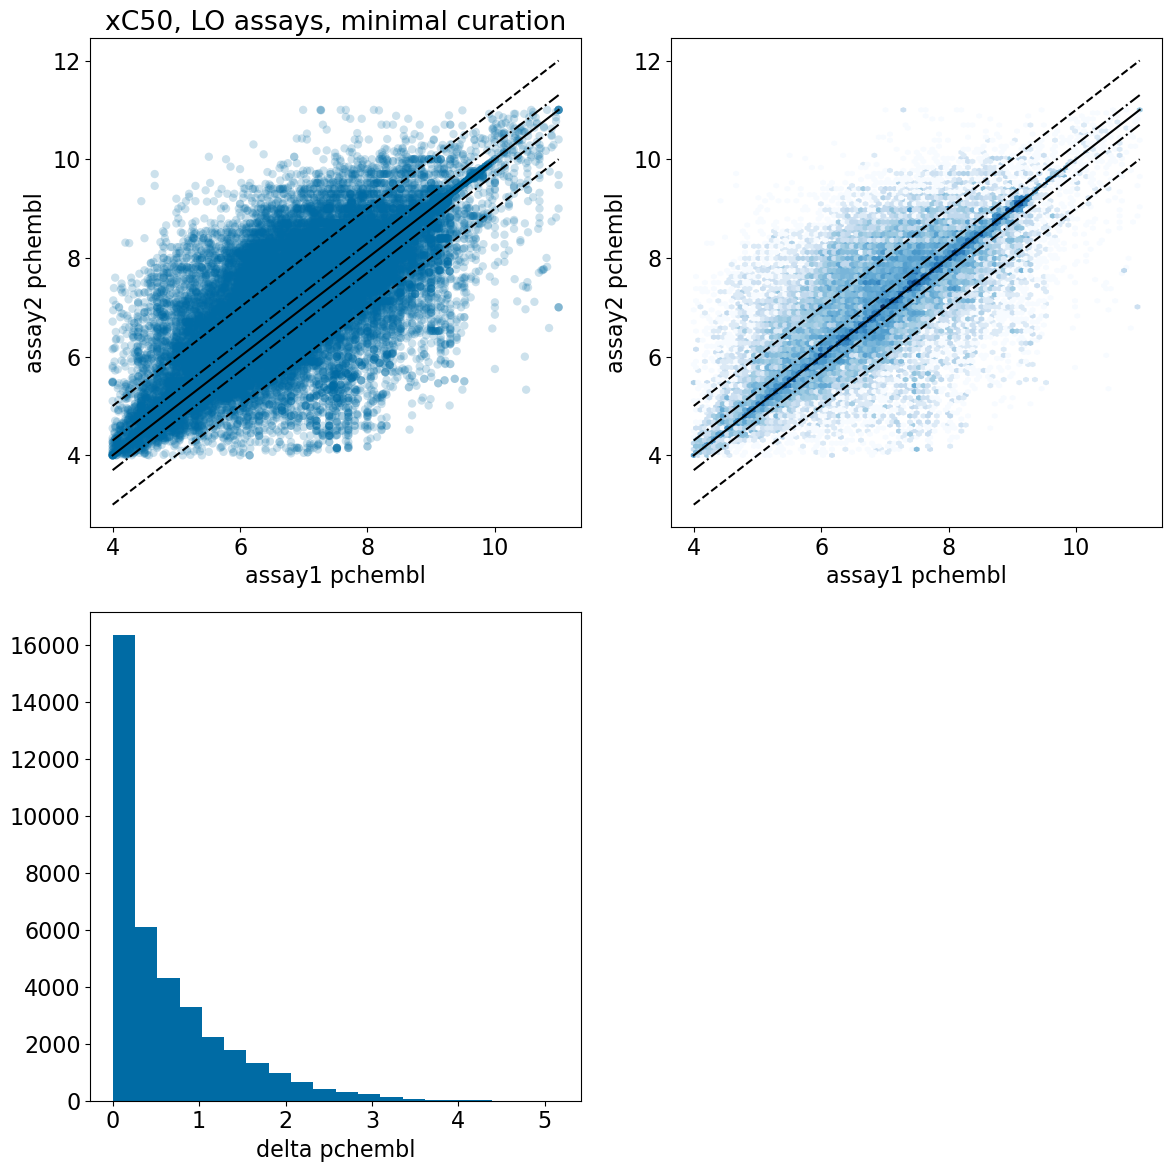

In [29]:
show_comparison(pts[tag],tag)

In [31]:
tag = 'IC50, LO assays, minimal curation'
pts[tag] = gather_data('IC50',noDuplicateDocs=False,removeMutants=False,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=False,
                       onlyDocs=False, onlyHighConfidence=False)

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 1776 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

1776 assay pairs.
R2=0.46, Spearman R=0.75 MAE=0.30
49047 points. Fraction > 0.3: 0.50, fraction > 1.0: 0.21
Fraction with different classifications:
	 bin=5: 0.04, kappa=0.60, balanced=0.78
	 [[44655, 855], [1518, 2019]]
	 bin=6: 0.12, kappa=0.64, balanced=0.81
	 [[34131, 2371], [3983, 8562]]
	 bin=7: 0.18, kappa=0.63, balanced=0.82
	 [[19963, 2929], [6219, 19936]]
	 bin=8: 0.14, kappa=0.60, balanced=0.83
	 [[8056, 2253], [4849, 33889]]
	 bin=9: 0.04, kappa=0.57, balanced=0.81
	 [[1663, 861], [1433, 45090]]


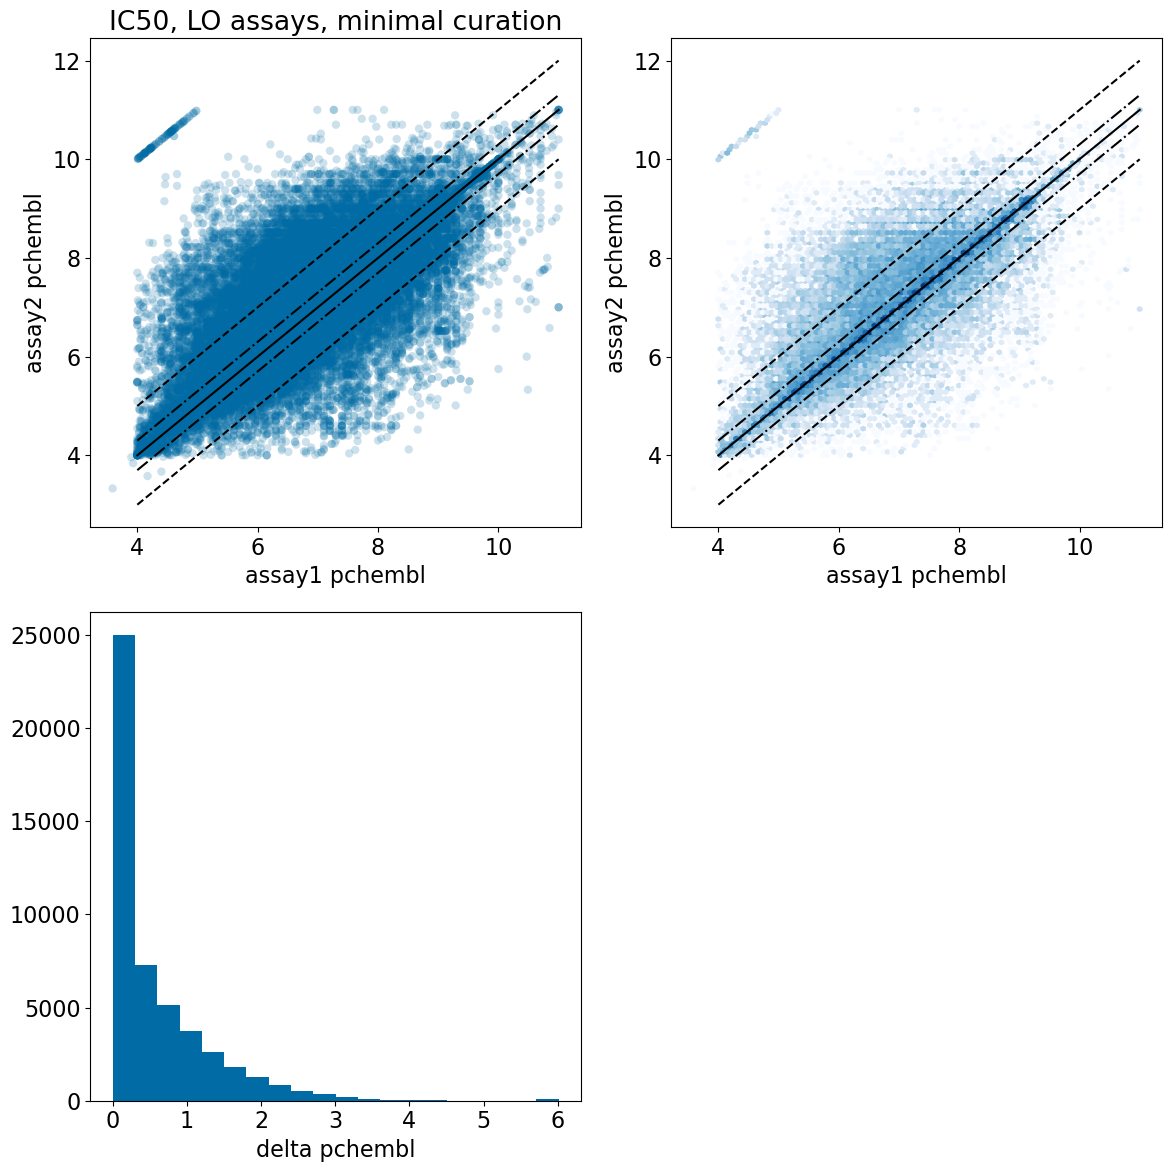

In [32]:
show_comparison(pts[tag],tag)

In [33]:
tag = 'Ki, LO assays, minimal curation'
pts[tag] = gather_data('Ki',noDuplicateDocs=False,removeMutants=False,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=False,
                       onlyDocs=False, onlyHighConfidence=False)

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 3135 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

3135 assay pairs.
R2=0.85, Spearman R=0.92 MAE=0.00
57975 points. Fraction > 0.3: 0.12, fraction > 1.0: 0.05
Fraction with different classifications:
	 bin=5: 0.02, kappa=0.90, balanced=0.95
	 [[50859, 662], [551, 5903]]
	 bin=6: 0.03, kappa=0.92, balanced=0.96
	 [[43548, 848], [828, 12751]]
	 bin=7: 0.06, kappa=0.88, balanced=0.94
	 [[30255, 1839], [1488, 24393]]
	 bin=8: 0.03, kappa=0.86, balanced=0.94
	 [[8245, 751], [1362, 47617]]
	 bin=9: 0.01, kappa=0.72, balanced=0.88
	 [[958, 291], [414, 56312]]


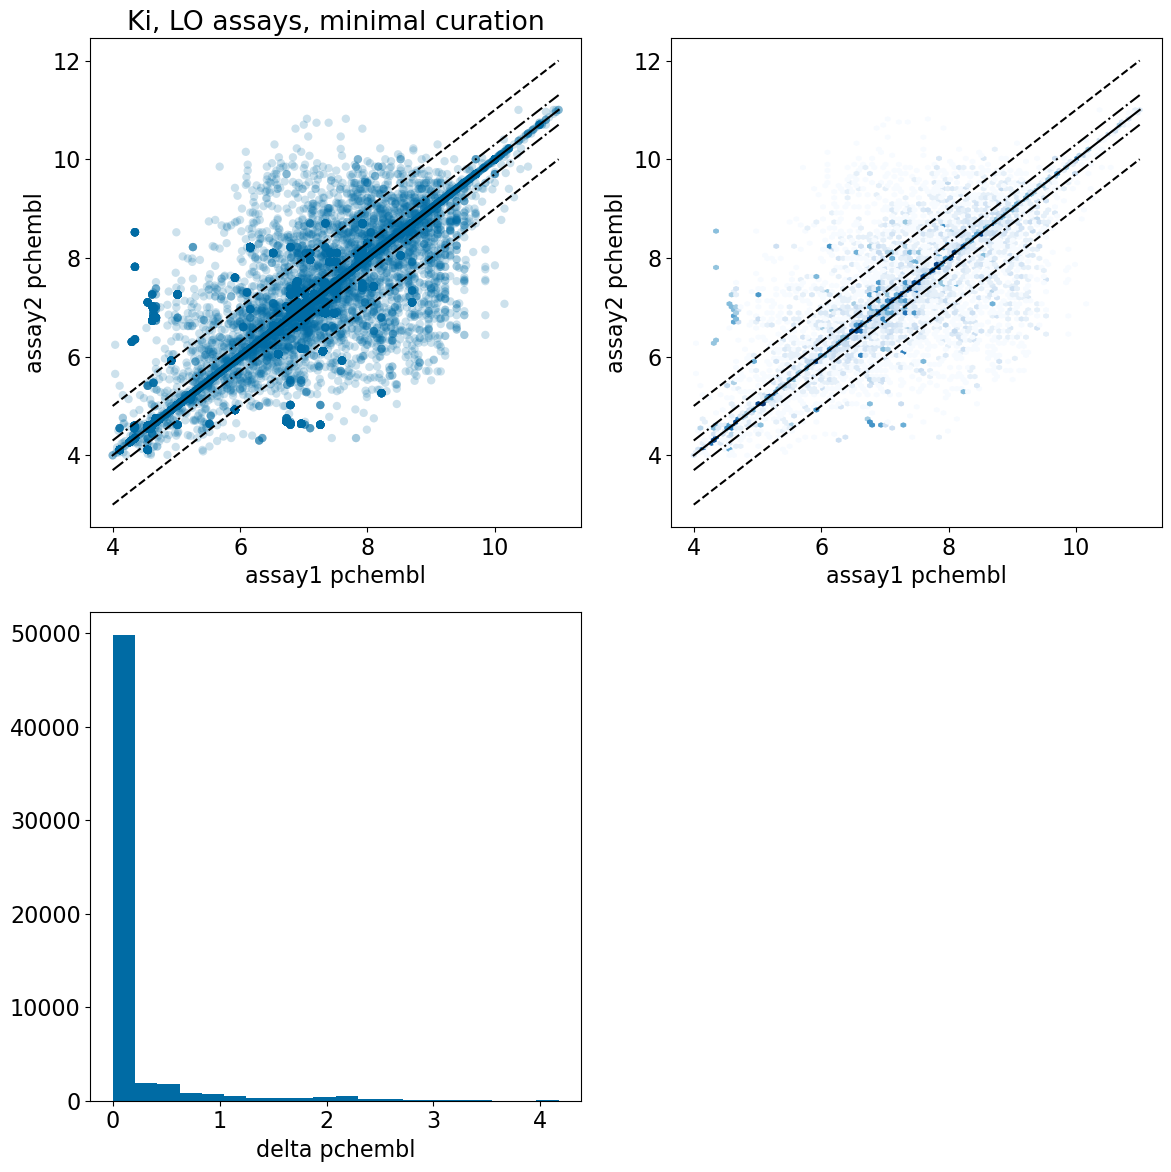

In [34]:
show_comparison(pts[tag],tag)

# Only activity curation

In [35]:
tag = 'xC50, LO assays, only activity curation'
pts[tag] = gather_data('xC50',noDuplicateDocs=False,removeMutants=False,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=True,
                       onlyDocs=False, onlyHighConfidence=False)

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 1807 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

1594 assay pairs.
R2=0.37, Spearman R=0.70 MAE=0.46
47009 points. Fraction > 0.3: 0.62, fraction > 1.0: 0.25
Fraction with different classifications:
	 bin=5: 0.05, kappa=0.52, balanced=0.74
	 [[42557, 1136], [1641, 1675]]
	 bin=6: 0.15, kappa=0.57, balanced=0.77
	 [[32578, 2884], [4337, 7210]]
	 bin=7: 0.22, kappa=0.55, balanced=0.78
	 [[18880, 3470], [7146, 17513]]
	 bin=8: 0.17, kappa=0.53, balanced=0.79
	 [[7478, 2610], [5683, 31238]]
	 bin=9: 0.05, kappa=0.50, balanced=0.78
	 [[1507, 1012], [1615, 42875]]


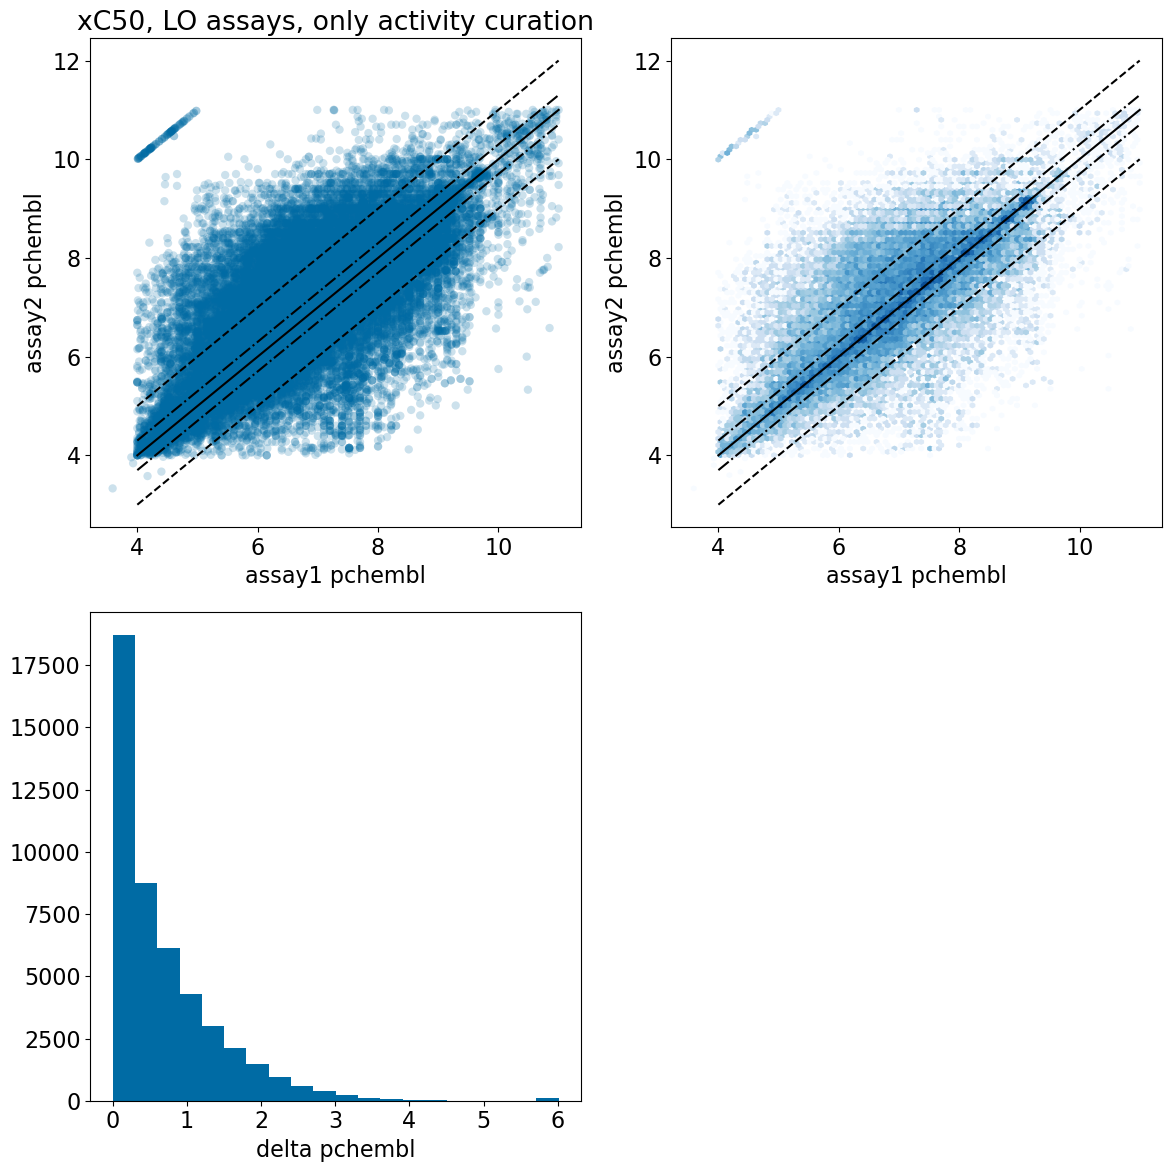

In [36]:
tag = 'xC50, LO assays, only activity curation'
show_comparison(pts[tag],tag)

In [37]:
tag = 'IC50, LO assays, only activity curation'
pts[tag] = gather_data('IC50',noDuplicateDocs=False,removeMutants=False,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=True,
                       onlyDocs=False, onlyHighConfidence=False)

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 1358 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

1358 assay pairs.
R2=0.35, Spearman R=0.70 MAE=0.45
40291 points. Fraction > 0.3: 0.61, fraction > 1.0: 0.25
Fraction with different classifications:
	 bin=5: 0.05, kappa=0.50, balanced=0.72
	 [[36632, 841], [1499, 1319]]
	 bin=6: 0.15, kappa=0.56, balanced=0.77
	 [[27781, 2340], [3961, 6209]]
	 bin=7: 0.22, kappa=0.55, balanced=0.78
	 [[15913, 2874], [6188, 15316]]
	 bin=8: 0.17, kappa=0.53, balanced=0.79
	 [[6285, 2219], [4821, 26966]]
	 bin=9: 0.05, kappa=0.49, balanced=0.78
	 [[1239, 849], [1422, 36781]]


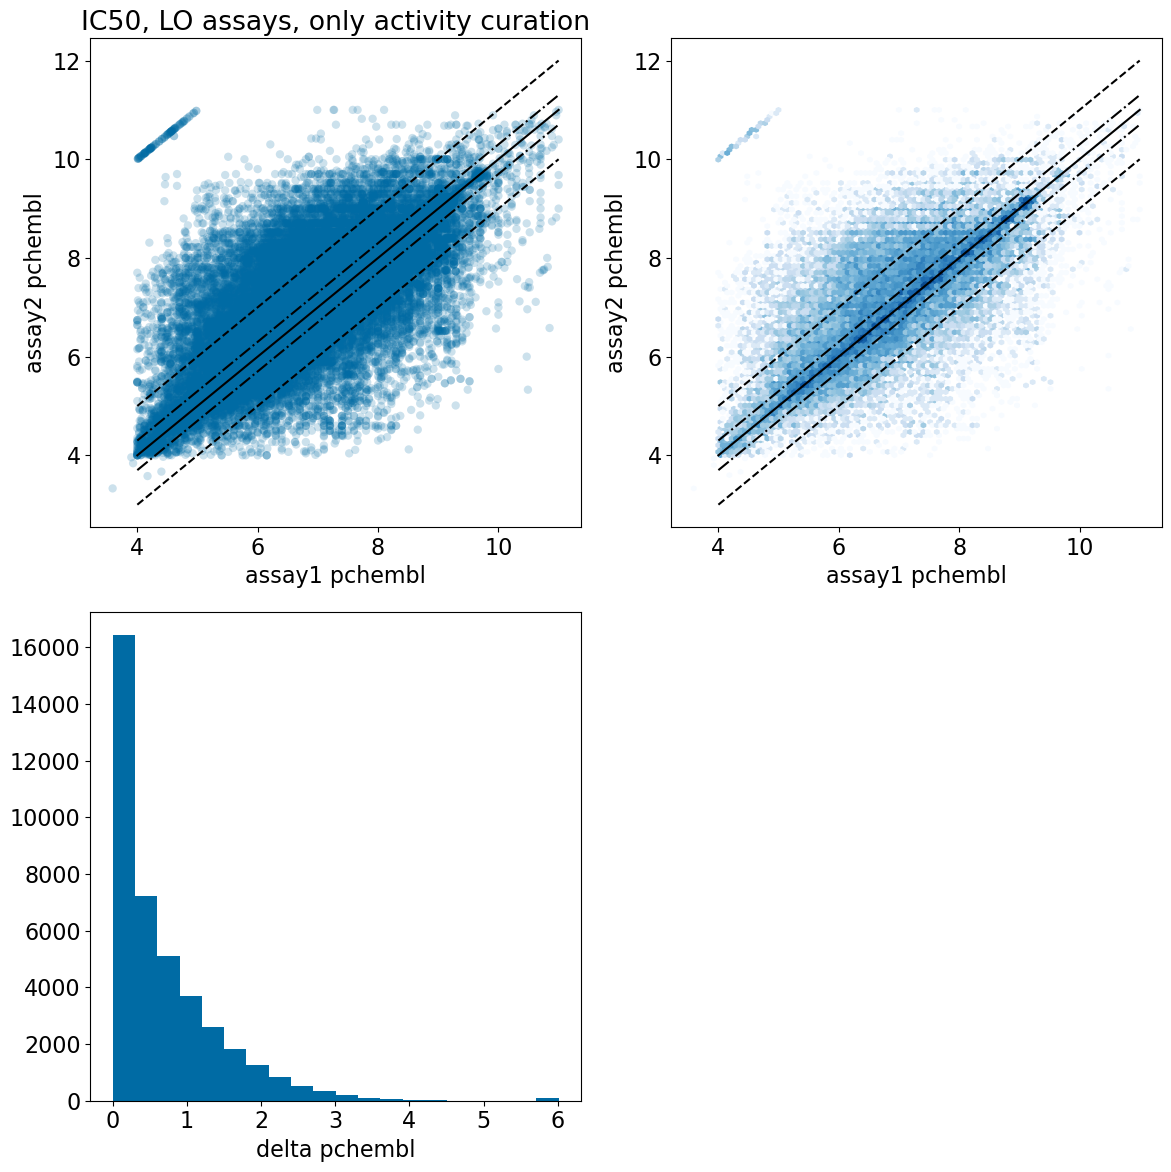

In [38]:
tag = 'IC50, LO assays, only activity curation'
show_comparison(pts[tag],tag)

In [39]:
tag = 'Ki, LO assays, only activity curation'
pts[tag] = gather_data('Ki',noDuplicateDocs=False,removeMutants=False,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=True,
                       onlyDocs=False, onlyHighConfidence=False)

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 587 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

587 assay pairs.
R2=0.61, Spearman R=0.80 MAE=0.01
15469 points. Fraction > 0.3: 0.34, fraction > 1.0: 0.15
Fraction with different classifications:
	 bin=5: 0.05, kappa=0.76, balanced=0.88
	 [[13406, 360], [377, 1326]]
	 bin=6: 0.07, kappa=0.80, balanced=0.90
	 [[11013, 611], [575, 3270]]
	 bin=7: 0.14, kappa=0.71, balanced=0.85
	 [[6889, 1114], [1132, 6334]]
	 bin=8: 0.10, kappa=0.64, balanced=0.83
	 [[1966, 687], [967, 11849]]
	 bin=9: 0.04, kappa=0.40, balanced=0.72
	 [[248, 283], [402, 14536]]


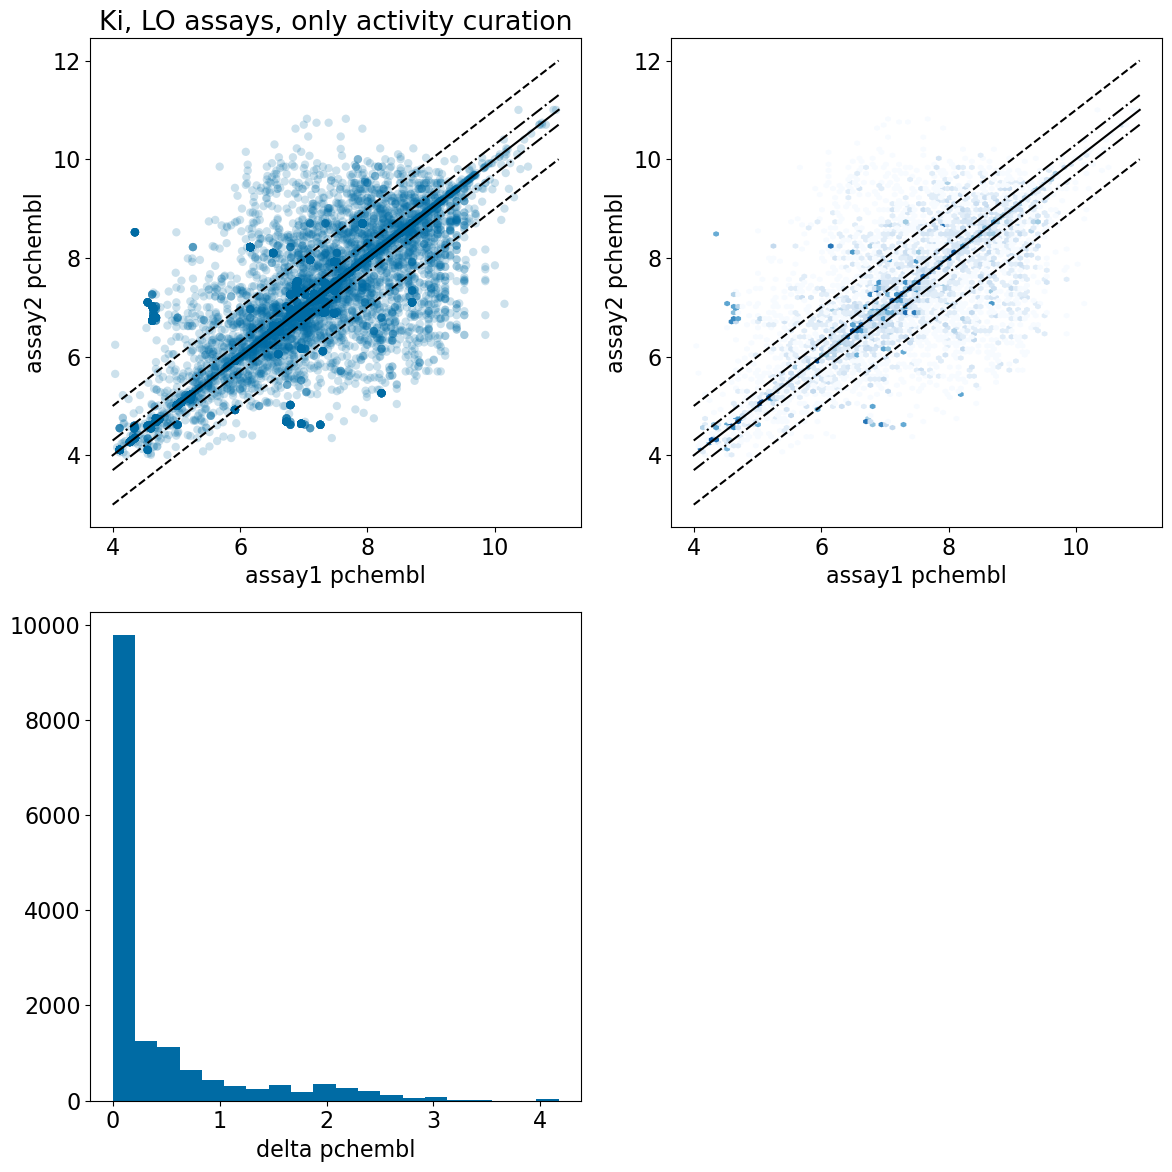

In [40]:
show_comparison(pts[tag],tag)

# Only activity, no duplicate docs

In [41]:
tag = 'xC50, LO assays, only activity curation, no dupe docs'
pts[tag] = gather_data('xC50',noDuplicateDocs=True,removeMutants=False,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=True,
                       onlyDocs=False, onlyHighConfidence=False)
tag = 'IC50, LO assays, only activity curation, no dupe docs'
pts[tag] = gather_data('IC50',noDuplicateDocs=True,removeMutants=False,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=True,
                       onlyDocs=False, onlyHighConfidence=False)
tag = 'Ki, LO assays, only activity curation, no dupe docs'
pts[tag] = gather_data('Ki',noDuplicateDocs=True,removeMutants=False,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=True,
                       onlyDocs=False, onlyHighConfidence=False)

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 273 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

241 assay pairs.
R2=0.21, Spearman R=0.73 MAE=0.16
4735 points. Fraction > 0.3: 0.43, fraction > 1.0: 0.17
Fraction with different classifications:
	 bin=5: 0.05, kappa=0.54, balanced=0.73
	 [[4328, 63], [184, 160]]
	 bin=6: 0.10, kappa=0.70, balanced=0.85
	 [[3410, 243], [254, 828]]
	 bin=7: 0.12, kappa=0.75, balanced=0.87
	 [[2140, 290], [304, 2001]]
	 bin=8: 0.16, kappa=0.55, balanced=0.77
	 [[748, 389], [390, 3208]]
	 bin=9: 0.07, kappa=0.35, balanced=0.69
	 [[118, 166], [195, 4256]]


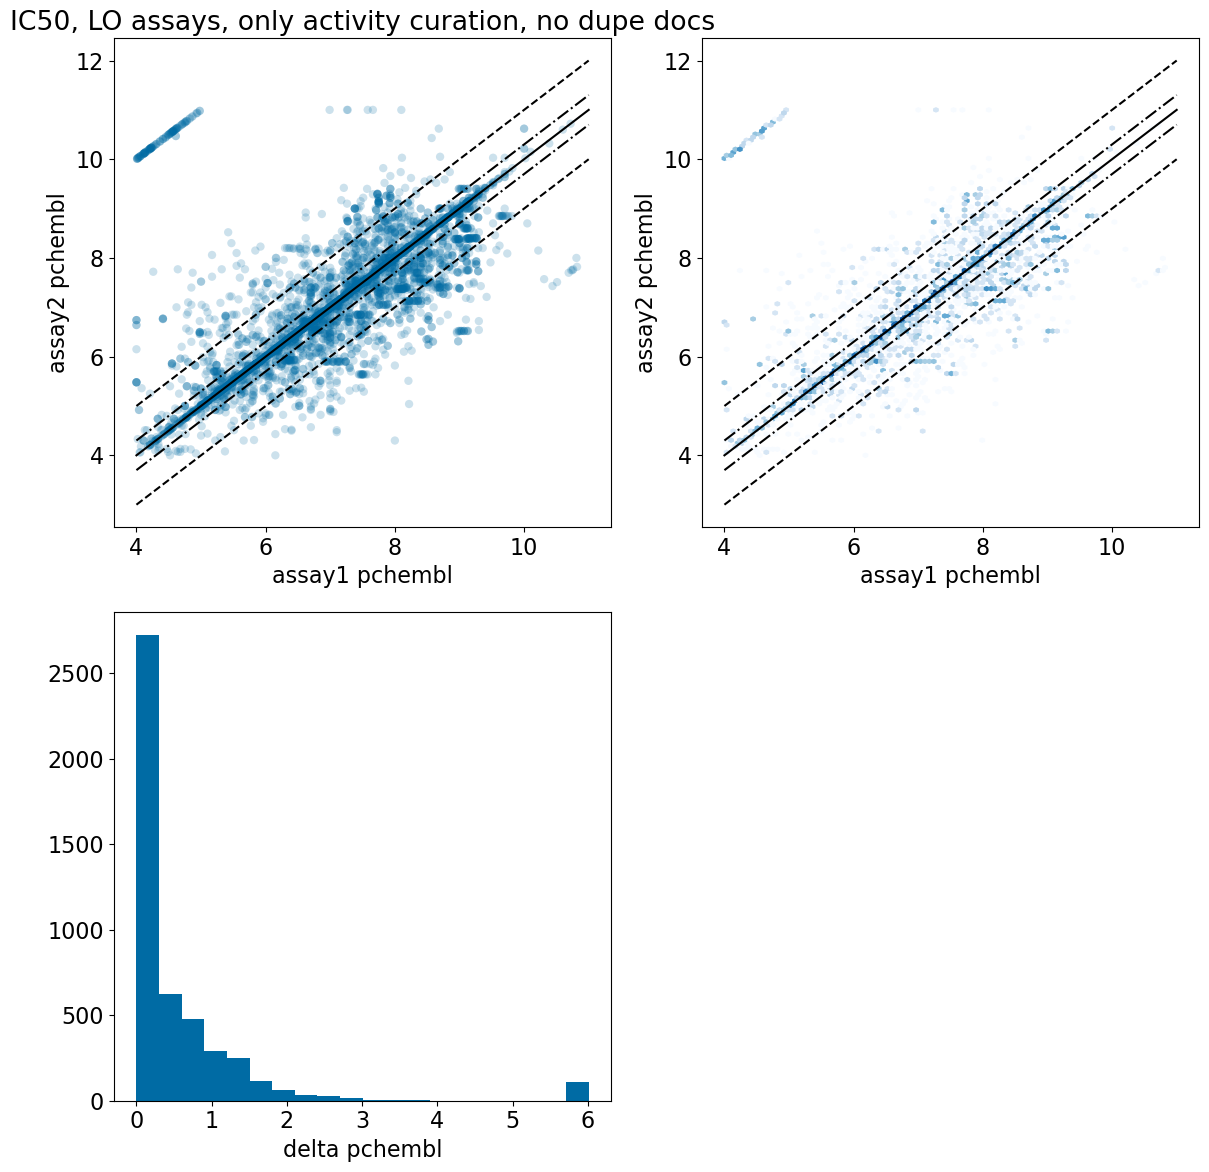

In [42]:
tag = 'IC50, LO assays, only activity curation, no dupe docs'
show_comparison(pts[tag],tag)

454 assay pairs.
R2=0.70, Spearman R=0.85 MAE=0.00
11679 points. Fraction > 0.3: 0.22, fraction > 1.0: 0.10
Fraction with different classifications:
	 bin=5: 0.05, kappa=0.77, balanced=0.88
	 [[9782, 300], [330, 1267]]
	 bin=6: 0.06, kappa=0.85, balanced=0.92
	 [[8028, 336], [372, 2943]]
	 bin=7: 0.12, kappa=0.77, balanced=0.88
	 [[5100, 607], [755, 5217]]
	 bin=8: 0.06, kappa=0.72, balanced=0.88
	 [[1163, 263], [482, 9771]]
	 bin=9: 0.01, kappa=0.52, balanced=0.72
	 [[98, 120], [54, 11407]]


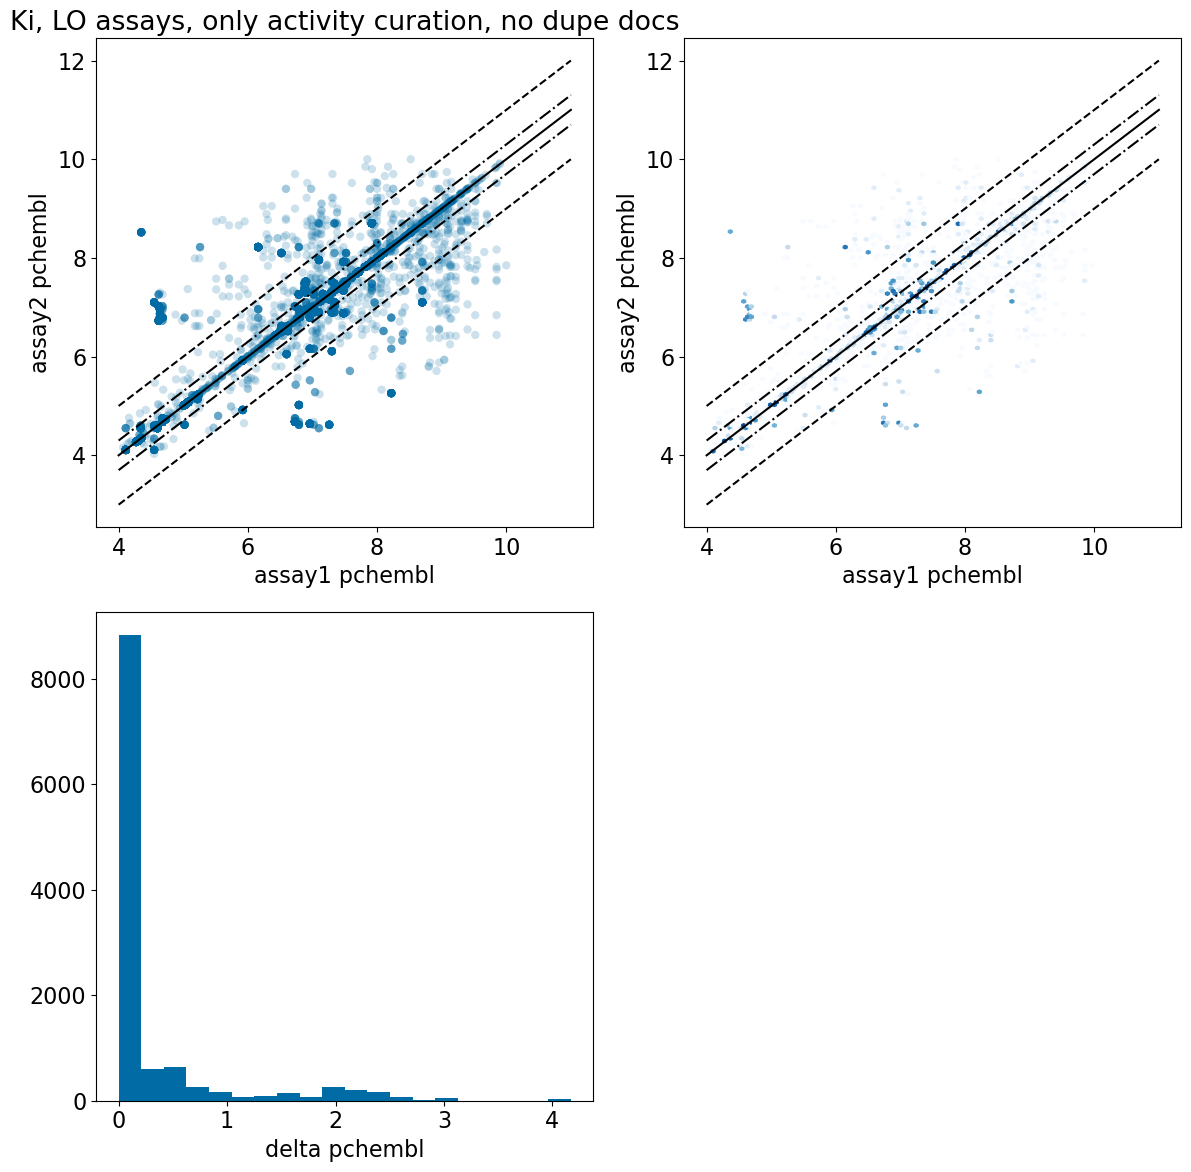

In [43]:
tag = 'Ki, LO assays, only activity curation, no dupe docs'
show_comparison(pts[tag],tag)

In [44]:
import gzip
import pickle
pickle.dump(pts,gzip.open('./curation_comparisons.pkl.gz','wb+'))

# Alternate views

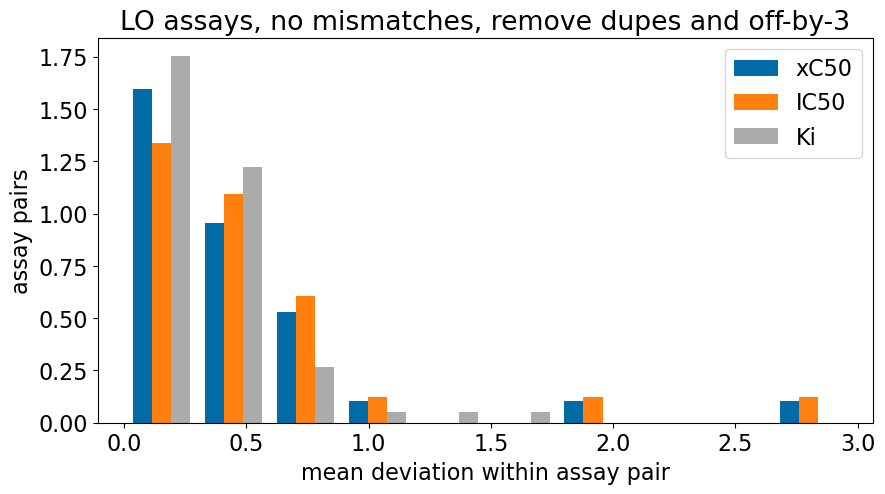

In [82]:
tags = ('xC50, LO assays, no mismatches, remove dupes and off-by-3',
        'IC50, LO assays, no mismatches, remove dupes and off-by-3',
        'Ki, LO assays, no mismatches, remove dupes and off-by-3',
)

means = {}
meds = {}
for tag in tags:
    accum = defaultdict(list)
    for row in pts[tag]:
        accum[tuple(row[-2:])].append(np.abs(row[1]-row[2]))
    means[tag] = [np.mean(x) for x in accum.values()]
    meds[tag] = [np.median(x) for x in accum.values()]

plt.figure(figsize=(10,5))
plt.hist(means.values(),label=('xC50','IC50','Ki'), bins=10, density=True);
plt.legend();
plt.title('LO assays, no mismatches, remove dupes and off-by-3')
plt.xlabel('mean deviation within assay pair')
plt.ylabel('assay pairs');

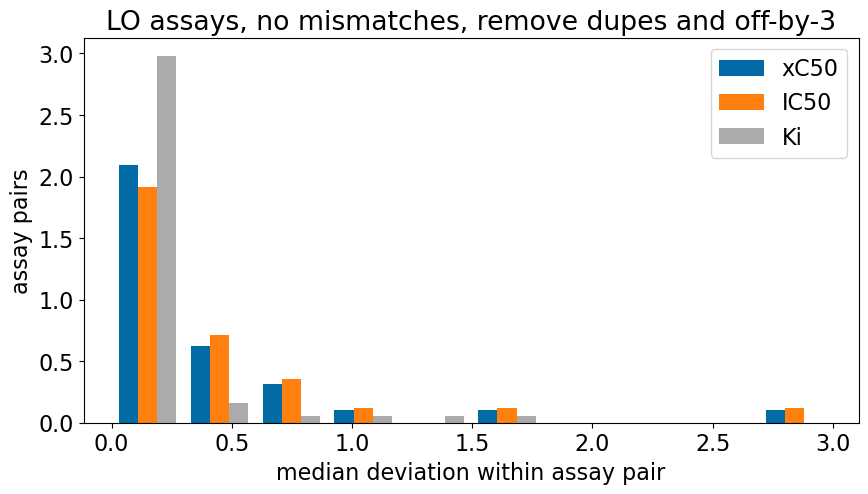

In [83]:
plt.figure(figsize=(10,5))
plt.hist(meds.values(),label=('xC50','IC50','Ki'), bins=10, density=True);
plt.legend();
plt.title('LO assays, no mismatches, remove dupes and off-by-3')
plt.xlabel('median deviation within assay pair')
plt.ylabel('assay pairs');

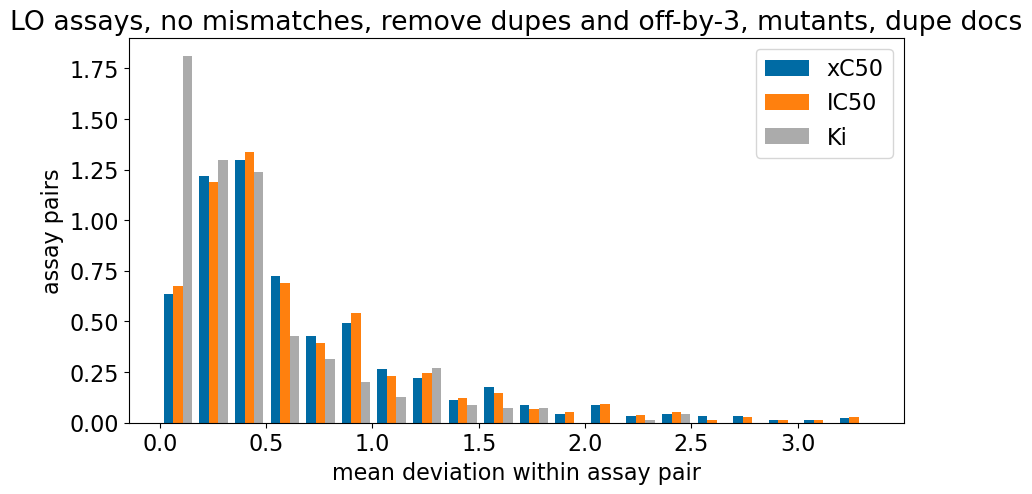

In [84]:
tags = ('xC50, LO assays, no mismatches, remove dupes and off-by-3, mutants, dupe docs',
        'IC50, LO assays, no mismatches, remove dupes and off-by-3, mutants, dupe docs',
        'Ki, LO assays, no mismatches, remove dupes and off-by-3, mutants, dupe docs',
)

means = {}
meds = {}
for tag in tags:
    accum = defaultdict(list)
    for row in pts[tag]:
        accum[tuple(row[-2:])].append(np.abs(row[1]-row[2]))
    means[tag] = [np.mean(x) for x in accum.values()]
    meds[tag] = [np.median(x) for x in accum.values()]

plt.figure(figsize=(10,5))
plt.hist(means.values(),label=('xC50','IC50','Ki'), bins=20, density=True);
plt.legend();
plt.title('LO assays, no mismatches, remove dupes and off-by-3, mutants, dupe docs')
plt.xlabel('mean deviation within assay pair')
plt.ylabel('assay pairs');

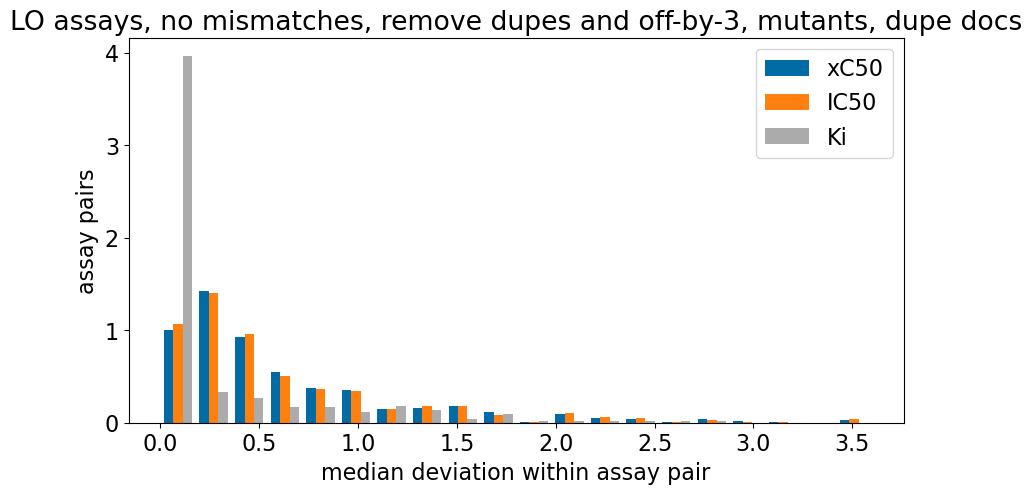

In [85]:
plt.figure(figsize=(10,5))
plt.hist(meds.values(),label=('xC50','IC50','Ki'), bins=20, density=True);
plt.legend();
plt.title('LO assays, no mismatches, remove dupes and off-by-3, mutants, dupe docs')
plt.xlabel('median deviation within assay pair')
plt.ylabel('assay pairs');

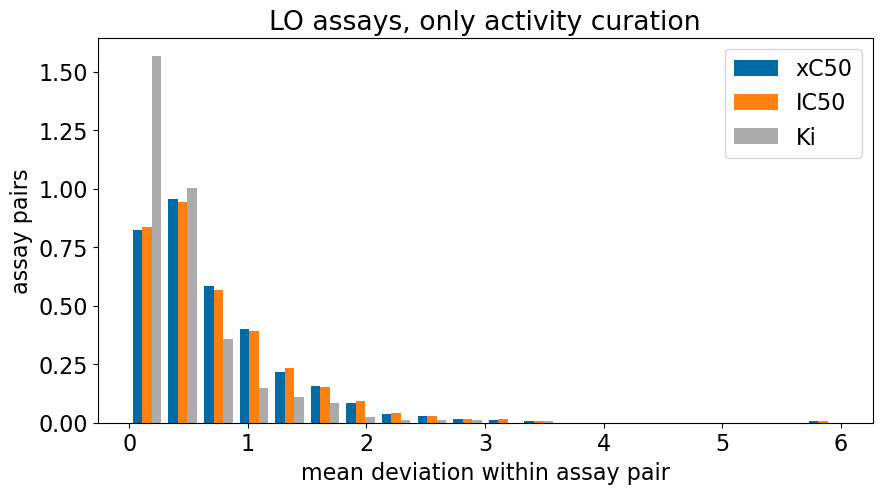

In [81]:
tags = ('xC50, LO assays, only activity curation',
        'IC50, LO assays, only activity curation',
        'Ki, LO assays, only activity curation',
)

means = {}
meds = {}
for tag in tags:
    accum = defaultdict(list)
    for row in pts[tag]:
        accum[tuple(row[-2:])].append(np.abs(row[1]-row[2]))
    means[tag] = [np.mean(x) for x in accum.values()]
    meds[tag] = [np.median(x) for x in accum.values()]

plt.figure(figsize=(10,5))
plt.hist(means.values(),label=('xC50','IC50','Ki'), bins=20, density=True);
plt.legend();
plt.title('LO assays, only activity curation')
plt.xlabel('mean deviation within assay pair')
plt.ylabel('assay pairs');

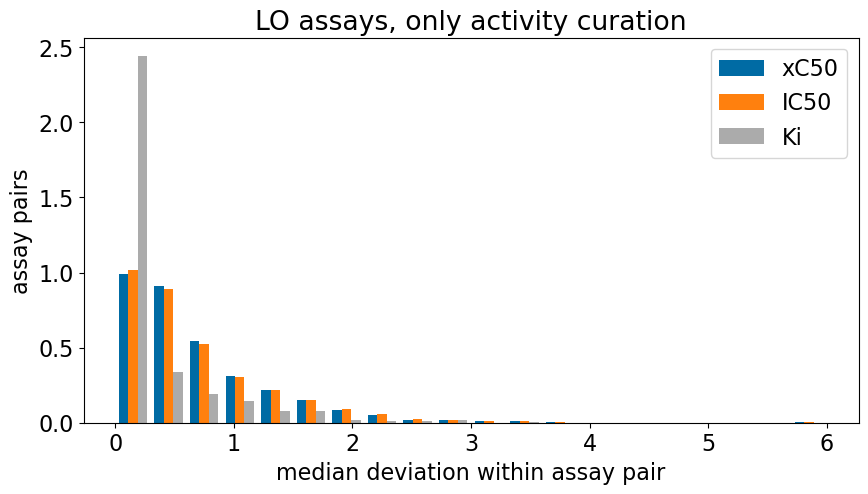

In [80]:
tags = ('xC50, LO assays, only activity curation',
        'IC50, LO assays, only activity curation',
        'Ki, LO assays, only activity curation',
)

means = {}
meds = {}
for tag in tags:
    accum = defaultdict(list)
    for row in pts[tag]:
        accum[tuple(row[-2:])].append(np.abs(row[1]-row[2]))
    means[tag] = [np.mean(x) for x in accum.values()]
    meds[tag] = [np.median(x) for x in accum.values()]

plt.figure(figsize=(10,5))
plt.hist(meds.values(),label=('xC50','IC50','Ki'), bins=20, density=True);
plt.legend();
plt.title('LO assays, only activity curation')
plt.xlabel('median deviation within assay pair')
plt.ylabel('assay pairs');

# Look at kappas based on binning within the assays

In [45]:
tags = ('xC50, LO assays, only activity curation',
        'IC50, LO assays, only activity curation',
        'Ki, LO assays, only activity curation',
)

kappas = {}
for tag in tags:
    p1s = defaultdict(list)
    p2s = defaultdict(list)
    for row in pts[tag]:
        key = tuple(row[-2:])
        p1s[key].append(row[1])
        p2s[key].append(row[2])
    kappas[tag] = {}
    for thresh in (5,6,7,8,9):
        kappas[tag][thresh] = []
        for key in p1s.keys():
            xp = np.array(p1s[key])
            yp = np.array(p2s[key])
            x_class = xp > thresh
            y_class = yp > thresh
            if sum(x_class)<2 or sum(y_class)<2 or (len(xp)-sum(x_class))<2 or (len(xp)-sum(y_class))<2:
#                 print('SKIP',tag,thresh,key,sum(x_class),sum(y_class),len(xp))
                continue
            kappa = cohen_kappa_score(x_class,y_class)
            kappas[tag][thresh].append(kappa)
            if(kappa<0.01):
                print(tag,thresh,key,kappa,sum(x_class),sum(y_class))    
            
            
            

xC50, LO assays, only activity curation 5 (688494, 688431) -0.04562737642585546 52 53
xC50, LO assays, only activity curation 5 (54254, 54222) -0.0923623445825934 39 28
xC50, LO assays, only activity curation 5 (2127286, 2127285) -0.11627906976744184 6 34
xC50, LO assays, only activity curation 5 (2104289, 2104288) -0.2465753424657533 24 19
xC50, LO assays, only activity curation 5 (737535, 737039) -0.12034383954154726 5 18
xC50, LO assays, only activity curation 5 (1700377, 1700376) -0.1499999999999999 21 17
xC50, LO assays, only activity curation 5 (954298, 954266) -0.02083333333333326 3 15
xC50, LO assays, only activity curation 5 (652247, 652246) -0.032786885245901676 18 13
xC50, LO assays, only activity curation 5 (878846, 878845) -0.01851851851851838 9 18
xC50, LO assays, only activity curation 5 (804419, 804416) -0.3157894736842106 4 6
xC50, LO assays, only activity curation 5 (66876, 63788) 0.0 10 8
xC50, LO assays, only activity curation 6 (646979, 646978) -0.00298730395817781

IC50, LO assays, only activity curation 7 (624870, 624869) -0.18867924528301883 15 8
IC50, LO assays, only activity curation 7 (2028067, 2028066) 0.0052459016393441305 2 39
IC50, LO assays, only activity curation 7 (62174, 62172) -0.035447761194029814 31 3
IC50, LO assays, only activity curation 7 (515463, 515200) -0.024774774774774633 32 8
IC50, LO assays, only activity curation 7 (963636, 963635) -0.16129032258064524 28 27
IC50, LO assays, only activity curation 7 (2127286, 2127285) -0.11627906976744184 2 30
IC50, LO assays, only activity curation 7 (62172, 61835) -0.06497175141242928 2 26
IC50, LO assays, only activity curation 7 (2127370, 2127368) -0.1428571428571428 3 5
IC50, LO assays, only activity curation 7 (624118, 624117) -0.018867924528301883 5 19
IC50, LO assays, only activity curation 7 (986596, 72868) -0.22399999999999998 3 14
IC50, LO assays, only activity curation 7 (2104289, 2104288) -0.09375 2 3
IC50, LO assays, only activity curation 7 (981893, 72872) -0.29411764705

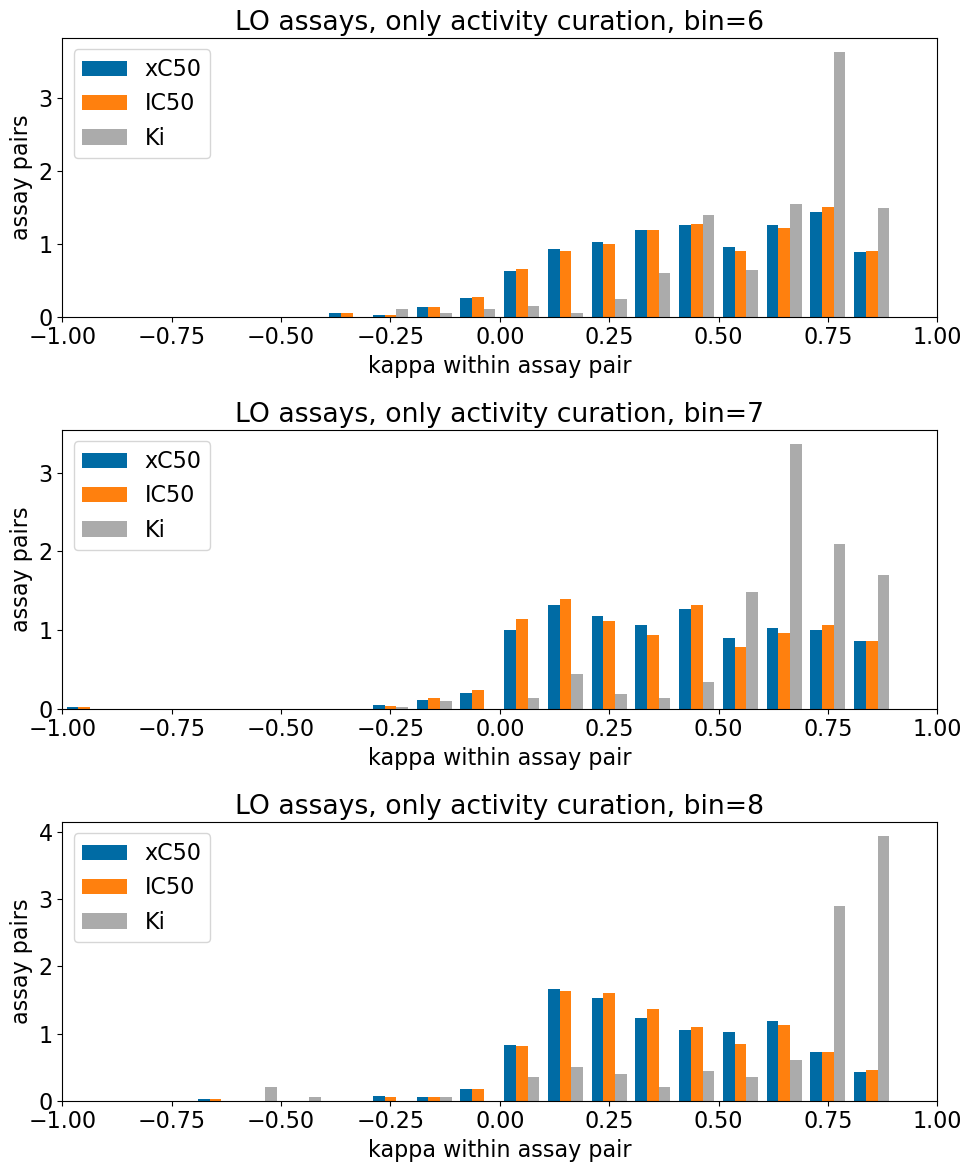

In [46]:
plt.figure(figsize=(10,12))
for i,thresh in enumerate((6,7,8)):
    plt.subplot(3,1,i+1)
    plt.hist([kappas[tag][thresh] for tag in tags],label=('xC50','IC50','Ki'), bins=np.arange(-1,1,0.1), density=True);
    plt.legend();
    plt.title(f'LO assays, only activity curation, bin={thresh}')
    plt.xlabel('kappa within assay pair')
    plt.ylabel('assay pairs');
    plt.xlim(-1,1)
plt.tight_layout()

In [47]:
tags = ('xC50, LO assays, no mismatches, remove dupes and off-by-3',
        'IC50, LO assays, no mismatches, remove dupes and off-by-3',
        'Ki, LO assays, no mismatches, remove dupes and off-by-3',
)

kappas = {}
for tag in tags:
    p1s = defaultdict(list)
    p2s = defaultdict(list)
    for row in pts[tag]:
        key = tuple(row[-2:])
        p1s[key].append(row[1])
        p2s[key].append(row[2])
    kappas[tag] = {}
    for thresh in (5,6,7,8,9):
        kappas[tag][thresh] = []
        for key in p1s.keys():
            xp = np.array(p1s[key])
            yp = np.array(p2s[key])
            x_class = xp > thresh
            y_class = yp > thresh
            if sum(x_class)<2 or sum(y_class)<2 or (len(xp)-sum(x_class))<2 or (len(xp)-sum(y_class))<2:
#                 print('SKIP',tag,thresh,key,sum(x_class),sum(y_class),len(xp))
                continue
            kappa = cohen_kappa_score(x_class,y_class)
            kappas[tag][thresh].append(kappa)
            if(kappa<0.01):
                print(tag,thresh,key,kappa,sum(x_class),sum(y_class))    
            
            
            

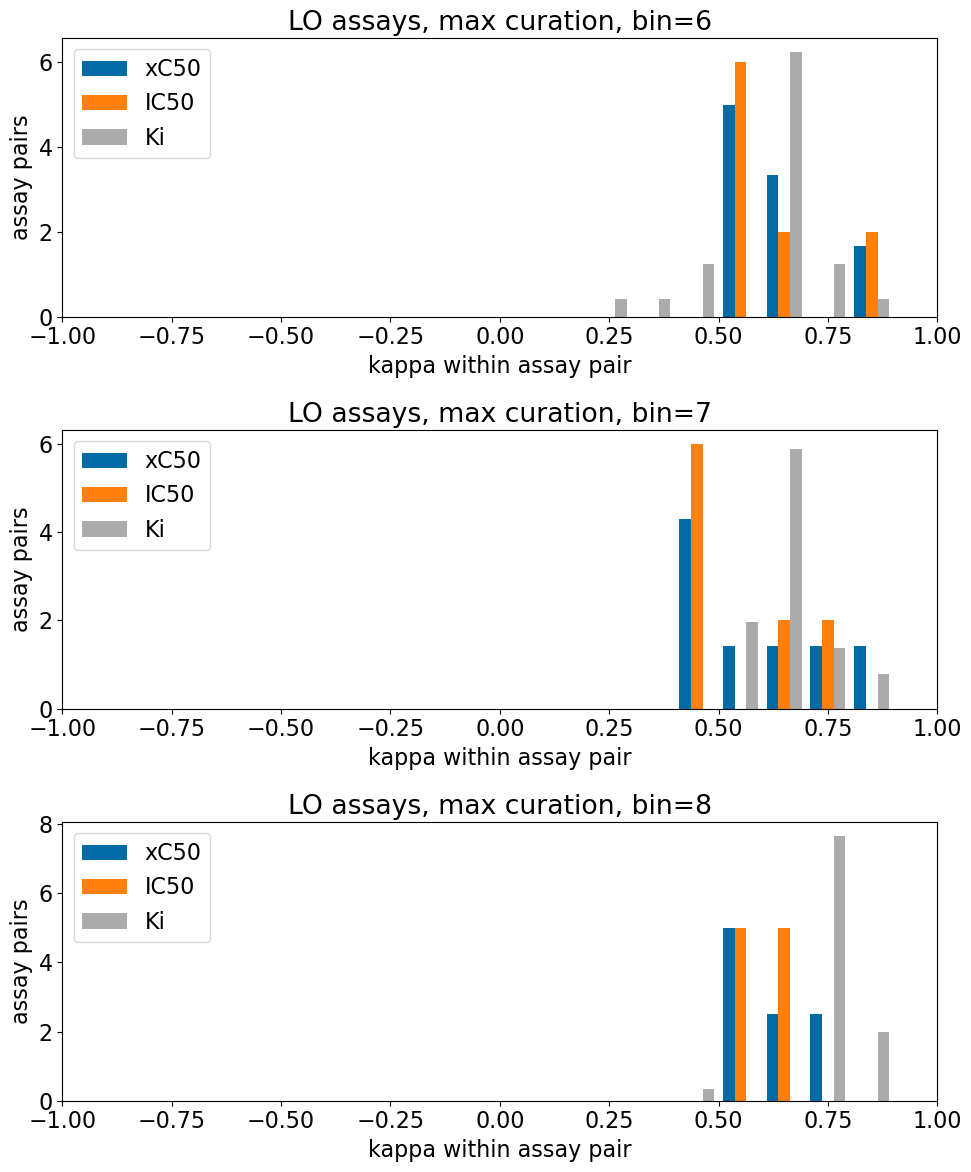

In [48]:
plt.figure(figsize=(10,12))
for i,thresh in enumerate((6,7,8)):
    plt.subplot(3,1,i+1)
    plt.hist([kappas[tag][thresh] for tag in tags],label=('xC50','IC50','Ki'), bins=np.arange(-1,1,0.1), density=True);
    plt.legend();
    plt.title(f'LO assays, max curation, bin={thresh}')
    plt.xlabel('kappa within assay pair')
    plt.ylabel('assay pairs');
    plt.xlim(-1,1)
plt.tight_layout()

In [49]:
tags = ('xC50 large, no mismatches, remove dupes and off-by-3',
        'IC50 large, no mismatches, remove dupes and off-by-3',
        'Ki large, no mismatches, remove dupes and off-by-3',
)

kappas = {}
for tag in tags:
    p1s = defaultdict(list)
    p2s = defaultdict(list)
    for row in pts[tag]:
        key = tuple(row[-2:])
        p1s[key].append(row[1])
        p2s[key].append(row[2])
    kappas[tag] = {}
    for thresh in (5,6,7,8,9):
        kappas[tag][thresh] = []
        for key in p1s.keys():
            xp = np.array(p1s[key])
            yp = np.array(p2s[key])
            x_class = xp > thresh
            y_class = yp > thresh
            if sum(x_class)<2 or sum(y_class)<2 or (len(xp)-sum(x_class))<2 or (len(xp)-sum(y_class))<2:
#                 print('SKIP',tag,thresh,key,sum(x_class),sum(y_class),len(xp))
                continue
            kappa = cohen_kappa_score(x_class,y_class)
            kappas[tag][thresh].append(kappa)
            if(kappa<0.01):
                print(tag,thresh,key,kappa,sum(x_class),sum(y_class))    
            
            

In [50]:
print(y_class),sum(y_class)

[False False False False False False False False False False False]


(None, 0)

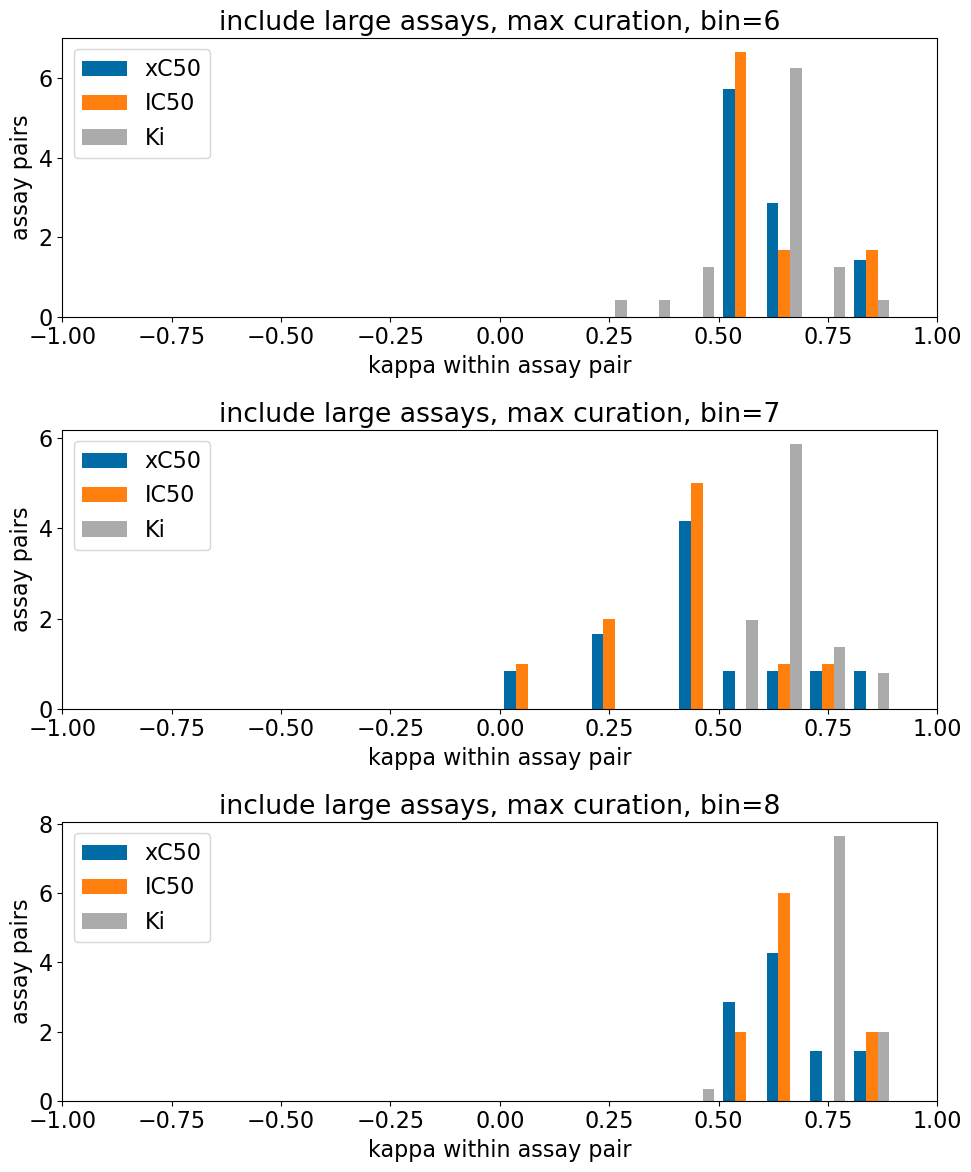

In [51]:
plt.figure(figsize=(10,12))
for i,thresh in enumerate((6,7,8)):
    plt.subplot(3,1,i+1)
    plt.hist([kappas[tag][thresh] for tag in tags],label=('xC50','IC50','Ki'), bins=np.arange(-1,1,0.1), density=True);
    plt.legend();
    plt.title(f'include large assays, max curation, bin={thresh}')
    plt.xlabel('kappa within assay pair')
    plt.ylabel('assay pairs');
    plt.xlim(-1,1)
plt.tight_layout()

In [52]:
[tag for tag in tags if np.sum(np.array(kappas[tag][7]) <0)]

[]

In [53]:
[tag for tag in tags if np.sum(np.abs(np.array(kappas[tag][7])) <.01)]

[]

IC50, LO assays, only activity curation, no dupe docs 5 (66876, 63788) 0.0 10 8
IC50, LO assays, only activity curation, no dupe docs 6 (1790985, 947686) -0.0813008130081303 72 66
IC50, LO assays, only activity curation, no dupe docs 6 (981893, 72872) -0.16417910447761175 22 13
IC50, LO assays, only activity curation, no dupe docs 6 (913220, 85969) 0.009433962264150941 11 19
IC50, LO assays, only activity curation, no dupe docs 6 (986596, 72869) -0.10000000000000009 10 13
IC50, LO assays, only activity curation, no dupe docs 7 (986596, 72868) -0.22399999999999998 3 14
IC50, LO assays, only activity curation, no dupe docs 7 (981893, 72872) -0.2941176470588236 6 5
IC50, LO assays, only activity curation, no dupe docs 7 (157792, 157789) 0.0 2 4
IC50, LO assays, only activity curation, no dupe docs 7 (157791, 157790) 0.0 4 4
Ki, LO assays, only activity curation, no dupe docs 7 (302861, 55400) -0.18181818181818188 23 20
Ki, LO assays, only activity curation, no dupe docs 7 (302861, 55401) 

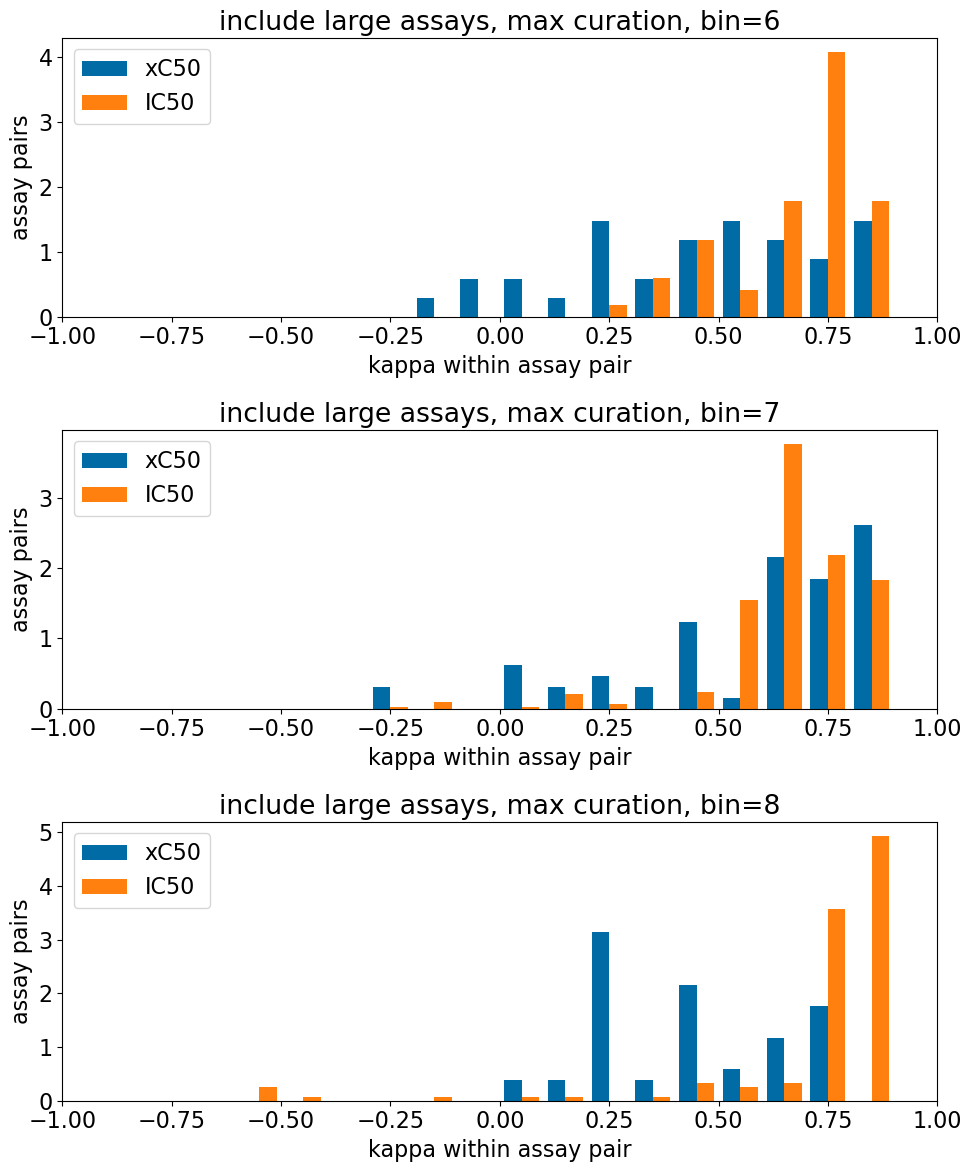

In [54]:
tags = (
        'IC50, LO assays, only activity curation, no dupe docs',
        'Ki, LO assays, only activity curation, no dupe docs',
)

kappas = {}
for tag in tags:
    p1s = defaultdict(list)
    p2s = defaultdict(list)
    for row in pts[tag]:
        key = tuple(row[-2:])
        p1s[key].append(row[1])
        p2s[key].append(row[2])
    kappas[tag] = {}
    for thresh in (5,6,7,8,9):
        kappas[tag][thresh] = []
        for key in p1s.keys():
            xp = np.array(p1s[key])
            yp = np.array(p2s[key])
            x_class = xp > thresh
            y_class = yp > thresh
            if sum(x_class)<2 or sum(y_class)<2 or (len(xp)-sum(x_class))<2 or (len(xp)-sum(y_class))<2:
#                 print('SKIP',tag,thresh,key,sum(x_class),sum(y_class),len(xp))
                continue
            kappa = cohen_kappa_score(x_class,y_class)
            kappas[tag][thresh].append(kappa)
            if(kappa<0.01):
                print(tag,thresh,key,kappa,sum(x_class),sum(y_class))    
            
plt.figure(figsize=(10,12))
for i,thresh in enumerate((6,7,8)):
    plt.subplot(3,1,i+1)
    plt.hist([kappas[tag][thresh] for tag in tags],label=('xC50','IC50','Ki'), bins=np.arange(-1,1,0.1), density=True);
    plt.legend();
    plt.title(f'include large assays, max curation, bin={thresh}')
    plt.xlabel('kappa within assay pair')
    plt.ylabel('assay pairs');
    plt.xlim(-1,1)
plt.tight_layout()            

# Anecdotes

## anecdote 1

In [164]:
tag = 'Ki large, no mismatches, remove dupes and off-by-3'
pts[tag]

[[2080, Decimal('9.06'), Decimal('9.22'), 302861, 55402],
 [27352, Decimal('9.08'), Decimal('9.52'), 302861, 55402],
 [27351, Decimal('8.96'), Decimal('9.40'), 302861, 55402],
 [27350, Decimal('9.11'), Decimal('9.22'), 302861, 55402],
 [27889, Decimal('7.05'), Decimal('6.73'), 302861, 55402],
 [27956, Decimal('9.13'), Decimal('8.62'), 302861, 55402],
 [27918, Decimal('9.08'), Decimal('8.70'), 302861, 55402],
 [28005, Decimal('7.00'), Decimal('7.38'), 302861, 55402],
 [27921, Decimal('6.96'), Decimal('7.96'), 302861, 55402],
 [27848, Decimal('8.89'), Decimal('9.05'), 302861, 55402],
 [27847, Decimal('7.00'), Decimal('8.64'), 302861, 55402],
 [27914, Decimal('7.14'), Decimal('9.10'), 302861, 55402],
 [27913, Decimal('9.10'), Decimal('9.00'), 302861, 55402],
 [28040, Decimal('7.14'), Decimal('8.96'), 302861, 55402],
 [27527, Decimal('9.04'), Decimal('7.90'), 302861, 55402],
 [28038, Decimal('8.02'), Decimal('9.00'), 302861, 55402],
 [27987, Decimal('7.43'), Decimal('8.15'), 302861, 55402]

In [ ]:
# Ki, LO assays, only activity curation 8 (216586, 55397) -0.20000000000000018 4 2   # < different mutants
# IC50, LO assays, only activity curation 8 (88045, 517) -0.05640423031727382 26 9  # < binding vs functional assay from the same paper

#IC50, LO assays, only activity curation 7 (981893, 72872) -0.2941176470588236 6 5 # < 981893 is a computational paper
#IC50, LO assays, only activity curation 7 (67815, 67680) -0.1186440677966103 8 10  # < binding vs functional (same paper)


# IC50, LO assays, only activity curation, no dupe docs 7 (986596, 72868) -0.22399999999999998 3 14 # < 986596 is a computational paper
# IC50, LO assays, only activity curation, no dupe docs 7 (981893, 72872) -0.2941176470588236 6 5 # < 981893 is a computational paper
# IC50, LO assays, only activity curation, no dupe docs 7 (157792, 157789) 0.0 2 4 # binding vs functional
# IC50, LO assays, only activity curation, no dupe docs 6 (1790985, 947686) -0.0813008130081303 72 66 # < 1790985 is a computational paper


In [246]:
aid1, aid2 = (1790985, 947686)
standard_type = 'IC50'
%sql \
select assay_id,assays.chembl_id assay,cid.chembl_id document from assays \
  join chembl_id_lookup cid on (doc_id=entity_id and entity_type='DOCUMENT') \
  where assay_id in (:aid1, :aid2)


 * postgresql://ccg_read@scotland/chembl_32


[(947686, 'CHEMBL2341125', 'CHEMBL2331403'),
 (1790985, 'CHEMBL4262904', 'CHEMBL4261543')]

In [248]:
d = %sql \
select cid.chembl_id compound,t1.pchembl_value pchembl1,t2.pchembl_value pchembl2 from \
   (select * from activities where assay_id=:aid1 and \
      standard_type=:standard_type and \
      pchembl_value is not null and standard_relation='=') t1 \
   cross join \
   (select * from activities where assay_id=:aid2 and \
      standard_type=:standard_type and \
      pchembl_value is not null and standard_relation='=') t2 \
   join chembl_id_lookup cid on (t1.molregno=entity_id and entity_type='COMPOUND') \
   where t1.molregno = t2.molregno;
d

 * postgresql://ccg_read@scotland/chembl_32


[('CHEMBL2335881', Decimal('6.72'), Decimal('6.46')),
 ('CHEMBL2335880', Decimal('6.89'), Decimal('6.48')),
 ('CHEMBL2335879', Decimal('7.28'), Decimal('6.77')),
 ('CHEMBL2335878', Decimal('7.05'), Decimal('6.64')),
 ('CHEMBL2335877', Decimal('6.46'), Decimal('6.55')),
 ('CHEMBL2335876', Decimal('6.92'), Decimal('6.46')),
 ('CHEMBL2335874', Decimal('6.11'), Decimal('5.19')),
 ('CHEMBL2335870', Decimal('6.22'), Decimal('5.15')),
 ('CHEMBL2335869', Decimal('6.04'), Decimal('5.42')),
 ('CHEMBL2335868', Decimal('6.43'), Decimal('5.70')),
 ('CHEMBL2335867', Decimal('6.88'), Decimal('6.02')),
 ('CHEMBL2335866', Decimal('6.58'), Decimal('5.75')),
 ('CHEMBL2335864', Decimal('7.11'), Decimal('6.72')),
 ('CHEMBL2335882', Decimal('7.54'), Decimal('6.64')),
 ('CHEMBL2335884', Decimal('7.00'), Decimal('6.39')),
 ('CHEMBL2335885', Decimal('7.50'), Decimal('7.35')),
 ('CHEMBL2335886', Decimal('6.68'), Decimal('6.01')),
 ('CHEMBL2335887', Decimal('6.82'), Decimal('6.18')),
 ('CHEMBL2335888', Decimal('7.24'), Decimal('7.20')),
 ('CHEMBL2335889', Decimal('7.17'), Decimal('6.40')),
 ('CHEMBL2335890', Decimal('6.78'), Decimal('6.07')),
 ('CHEMBL2335893', Decimal('7.57'), Decimal('7.22')),
 ('CHEMBL2335894', Decimal('7.29'), Decimal('6.80')),
 ('CHEMBL2335896', Decimal('7.72'), Decimal('7.47')),
 ('CHEMBL2335897', Decimal('6.59'), Decimal('7.35')),
 ('CHEMBL2335899', Decimal('6.99'), Decimal('7.60')),
 ('CHEMBL2335900', Decimal('6.59'), Decimal('6.85')),
 ('CHEMBL2335901', Decimal('6.64'), Decimal('6.16')),
 ('CHEMBL2335902', Decimal('6.67'), Decimal('7.13')),
 ('CHEMBL2335903', Decimal('7.43'), Decimal('8.40')),
 ('CHEMBL2335904', Decimal('7.03'), Decimal('8.30')),
 ('CHEMBL2335905', Decimal('6.80'), Decimal('8.10')),
 ('CHEMBL2335906', Decimal('7.41'), Decimal('7.20')),
 ('CHEMBL2335908', Decimal('6.85'), Decimal('7.60')),
 ('CHEMBL2335909', Decimal('5.64'), Decimal('6.37')),
 ('CHEMBL2335910', Decimal('6.73'), Decimal('7.70')),
 ('CHEMBL2335911', Decimal('5.58'), Decimal('6.24')),
 ('CHEMBL2335912', Decimal('7.09'), Decimal('7.60')),
 ('CHEMBL2335864', Decimal('7.11'), Decimal('6.72')),
 ('CHEMBL2335866', Decimal('6.58'), Decimal('5.75')),
 ('CHEMBL2335867', Decimal('6.88'), Decimal('6.02')),
 ('CHEMBL2335868', Decimal('6.43'), Decimal('5.70')),
 ('CHEMBL2335869', Decimal('6.04'), Decimal('5.42')),
 ('CHEMBL2335870', Decimal('6.22'), Decimal('5.15')),
 ('CHEMBL2335874', Decimal('6.11'), Decimal('5.19')),
 ('CHEMBL2335876', Decimal('6.92'), Decimal('6.46')),
 ('CHEMBL2335877', Decimal('6.46'), Decimal('6.55')),
 ('CHEMBL2335878', Decimal('7.05'), Decimal('6.64')),
 ('CHEMBL2335879', Decimal('7.28'), Decimal('6.77')),
 ('CHEMBL2335880', Decimal('6.89'), Decimal('6.48')),
 ('CHEMBL2335881', Decimal('6.52'), Decimal('6.46')),
 ('CHEMBL2335882', Decimal('7.54'), Decimal('6.64')),
 ('CHEMBL2335884', Decimal('7.00'), Decimal('6.39')),
 ('CHEMBL2335885', Decimal('7.49'), Decimal('7.35')),
 ('CHEMBL2335886', Decimal('6.68'), Decimal('6.01')),
 ('CHEMBL2335887', Decimal('6.82'), Decimal('6.18')),
 ('CHEMBL2335888', Decimal('7.24'), Decimal('7.20')),
 ('CHEMBL2335889', Decimal('7.17'), Decimal('6.40')),
 ('CHEMBL2335890', Decimal('6.77'), Decimal('6.07')),
 ('CHEMBL2335893', Decimal('7.57'), Decimal('7.22')),
 ('CHEMBL2335894', Decimal('7.29'), Decimal('6.80')),
 ('CHEMBL2335896', Decimal('7.24'), Decimal('7.47')),
 ('CHEMBL2335897', Decimal('6.60'), Decimal('7.35')),
 ('CHEMBL2335899', Decimal('6.99'), Decimal('7.60')),
 ('CHEMBL2335900', Decimal('6.59'), Decimal('6.85')),
 ('CHEMBL2335901', Decimal('6.64'), Decimal('6.16')),
 ('CHEMBL2335902', Decimal('6.67'), Decimal('7.13')),
 ('CHEMBL2335903', Decimal('7.43'), Decimal('8.40')),
 ('CHEMBL2335904', Decimal('7.03'), Decimal('8.30')),
 ('CHEMBL2335905', Decimal('6.80'), Decimal('8.10')),
 ('CHEMBL2335906', Decimal('7.41'), Decimal('7.20')),
 ('CHEMBL2335908', Decimal('6.85'), Decimal('7.60')),
 ('CHEMBL2335909', Decimal('5.64'), Decimal('6.37')),
 ('CHEMBL2335910', Decimal('6.73'), Decimal('7.70')),
 ('C

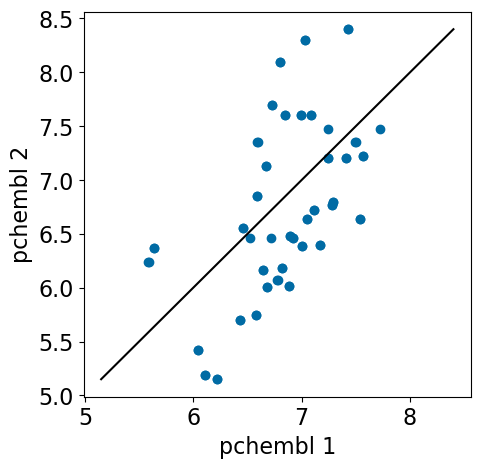

In [249]:
plt.figure(figsize=(5,5))
lbl,xp,yp = zip(*d)
plt.scatter(xp,yp);
minv = min(xp+yp)
maxv = max(xp+yp)
plt.plot((minv,maxv),(minv,maxv),'k-');
plt.xlabel('pchembl 1')
plt.ylabel('pchembl 2');
#minv = min()

In [129]:
d = %sql \
select t1.* from \
   (select * from activities where assay_id=302861 and \
      standard_type='Ki' and \
      pchembl_value is not null and standard_relation='=') t1 \
   join chembl_id_lookup cid on (t1.molregno=entity_id and entity_type='COMPOUND') \
   where cid.chembl_id='CHEMBL7005';
d

 * postgresql://ccg_read@scotland/chembl_32


[(1464869, 302861, 21047, 378876, 1133, '=', Decimal('170.0'), 'nM', 1, 'Ki', None, None, 0, Decimal('6.77'), 'BAO_0000192', 'UO_0000065', 'http://www.openphacts.org/units/Nanomolar', None, None, None, 1, 'Ki', '=', Decimal('170.0'), 'nM', None, None)]

In [130]:
%sql select * from assays where assay_id=302861;

 * postgresql://ccg_read@scotland/chembl_32


[(302861, 21047, 'Inhibition constant against Plasmodium falciparum dihydrofolate reductase', 'B', None, None, 'Plasmodium falciparum', 5833, None, None, None, None, 70, 'H', 8, 'Intermediate', 1, None, 'CHEMBL828776', None, 'BAO_0000357', None, None, 'CLD0')]

## Anecdote 2

In [134]:
%sql \
select assay_id,assays.chembl_id assay,cid.chembl_id document from assays \
  join chembl_id_lookup cid on (doc_id=entity_id and entity_type='DOCUMENT') \
  where assay_id in (1349400, 590237)


 * postgresql://ccg_read@scotland/chembl_32


[(590237, 'CHEMBL1059274', 'CHEMBL1154193'),
 (1349400, 'CHEMBL3269990', 'CHEMBL3259683')]

In [132]:
d = %sql \
select cid.chembl_id compound,t1.pchembl_value pchembl1,t2.pchembl_value pchembl2 from \
   (select * from activities where assay_id=1349400 and \
      standard_type='Ki' and \
      pchembl_value is not null and standard_relation='=') t1 \
   cross join \
   (select * from activities where assay_id=590237 and \
      standard_type='Ki' and \
      pchembl_value is not null and standard_relation='=') t2 \
   join chembl_id_lookup cid on (t1.molregno=entity_id and entity_type='COMPOUND') \
   where t1.molregno = t2.molregno;
d

 * postgresql://ccg_read@scotland/chembl_32


[('CHEMBL567820', Decimal('4.67'), Decimal('6.91')),
 ('CHEMBL567821', Decimal('4.98'), Decimal('6.73')),
 ('CHEMBL573209', Decimal('4.88'), Decimal('6.85')),
 ('CHEMBL574452', Decimal('5.94'), Decimal('4.65')),
 ('CHEMBL572526', Decimal('6.11'), Decimal('6.80')),
 ('CHEMBL575341', Decimal('5.89'), Decimal('6.85')),
 ('CHEMBL575342', Decimal('4.95'), Decimal('5.27')),
 ('CHEMBL408619', Decimal('6.98'), Decimal('7.67')),
 ('CHEMBL572753', Decimal('7.11'), Decimal('7.49')),
 ('CHEMBL270670', Decimal('7.96'), Decimal('6.15')),
 ('CHEMBL566297', Decimal('8.15'), Decimal('7.06'))]

Text(0, 0.5, 'pchembl 2')

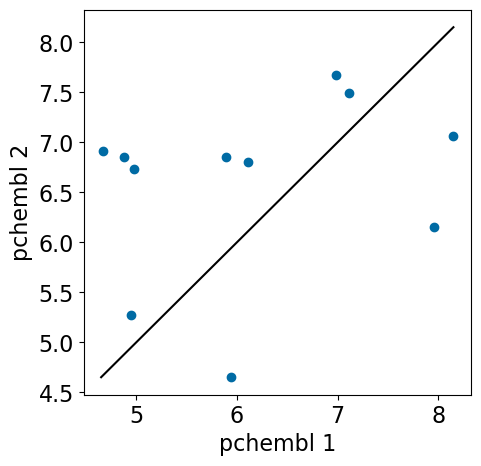

In [133]:
plt.figure(figsize=(5,5))
lbl,xp,yp = zip(*d)
plt.scatter(xp,yp);
minv = min(xp+yp)
maxv = max(xp+yp)
plt.plot((minv,maxv),(minv,maxv),'k-');
plt.xlabel('pchembl 1')
plt.ylabel('pchembl 2')
#minv = min()

# IC50 anecdotes

```
IC50 large, no mismatches, remove dupes and off-by-3 8 (1527924, 1527877) 0.0
IC50 large, no mismatches, remove dupes and off-by-3 8 (1527924, 1527907) 0.0


IC50 large, no mismatches, remove dupes and off-by-3 5 (66876, 63788) 0.0
IC50 large, no mismatches, remove dupes and off-by-3 5 (159742, 157693) 0.0

IC50 large, no mismatches, remove dupes and off-by-3 7 (205406, 142881) 0.0
IC50 large, no mismatches, remove dupes and off-by-3 7 (2127326, 1528775) 0.0
```

In [168]:
tag = 'IC50 large, no mismatches, remove dupes and off-by-3'

In [169]:
pts[tag]

[[2039688, Decimal('5.71'), Decimal('5.55'), 1536920, 1536754],
 [2039689, Decimal('7.00'), Decimal('6.38'), 1536920, 1536754],
 [2039691, Decimal('6.77'), Decimal('6.36'), 1536920, 1536754],
 [2039692, Decimal('5.44'), Decimal('5.80'), 1536920, 1536754],
 [2039693, Decimal('6.77'), Decimal('6.24'), 1536920, 1536754],
 [2039695, Decimal('6.43'), Decimal('6.19'), 1536920, 1536754],
 [2039696, Decimal('5.71'), Decimal('6.35'), 1536920, 1536754],
 [2039697, Decimal('6.57'), Decimal('6.19'), 1536920, 1536754],
 [2039699, Decimal('6.68'), Decimal('6.08'), 1536920, 1536754],
 [2039700, Decimal('4.29'), Decimal('4.25'), 1536920, 1536754],
 [2039701, Decimal('6.40'), Decimal('6.51'), 1536920, 1536754],
 [2039703, Decimal('6.85'), Decimal('6.10'), 1536920, 1536754],
 [2039876, Decimal('6.32'), Decimal('5.90'), 1536920, 1536754],
 [2039877, Decimal('6.70'), Decimal('6.43'), 1536920, 1536754],
 [2039878, Decimal('5.58'), Decimal('5.50'), 1536920, 1536754],
 [2039879, Decimal('6.62'), Decimal('6.6

In [183]:
%sql \
select assay_id,assays.chembl_id assay,cid.chembl_id document from assays \
  join chembl_id_lookup cid on (doc_id=entity_id and entity_type='DOCUMENT') \
  where assay_id in (205406, 142881)


 * postgresql://ccg_read@scotland/chembl_32


[(142881, 'CHEMBL751716', 'CHEMBL1150559'),
 (205406, 'CHEMBL812229', 'CHEMBL1129219')]

In [184]:
d = %sql \
select cid.chembl_id compound,t1.pchembl_value pchembl1,t2.pchembl_value pchembl2 from \
   (select * from activities where assay_id=205406 and \
      standard_type='IC50' and \
      pchembl_value is not null and standard_relation='=') t1 \
   cross join \
   (select * from activities where assay_id=142881 and \
      standard_type='IC50' and \
      pchembl_value is not null and standard_relation='=') t2 \
   join chembl_id_lookup cid on (t1.molregno=entity_id and entity_type='COMPOUND') \
   where t1.molregno = t2.molregno;
d

 * postgresql://ccg_read@scotland/chembl_32


[('CHEMBL95127', Decimal('8.12'), Decimal('7.68')),
 ('CHEMBL94834', Decimal('8.16'), Decimal('6.93')),
 ('CHEMBL327497', Decimal('8.21'), Decimal('6.21')),
 ('CHEMBL330719', Decimal('8.13'), Decimal('7.43')),
 ('CHEMBL328511', Decimal('8.12'), Decimal('7.64')),
 ('CHEMBL330499', Decimal('8.13'), Decimal('7.44')),
 ('CHEMBL93556', Decimal('8.13'), Decimal('7.51')),
 ('CHEMBL264007', Decimal('8.19'), Decimal('6.53')),
 ('CHEMBL96442', Decimal('8.12'), Decimal('7.57')),
 ('CHEMBL330172', Decimal('8.12'), Decimal('7.57')),
 ('CHEMBL322194', Decimal('8.12'), Decimal('7.58'))]

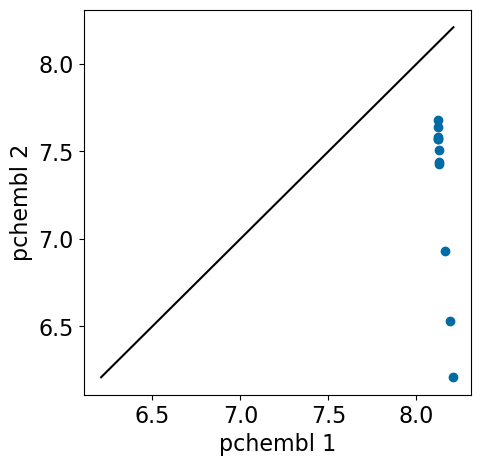

In [185]:
plt.figure(figsize=(5,5))
lbl,xp,yp = zip(*d)
plt.scatter(xp,yp);
minv = min(xp+yp)
maxv = max(xp+yp)
plt.plot((minv,maxv),(minv,maxv),'k-');
plt.xlabel('pchembl 1')
plt.ylabel('pchembl 2');
#minv = min()

# More

In [ ]:
pts['IC50, only assay_type, remove dupes and off-by-3'] = gather_data('IC50',maxMatch=False,maxAssaySize=10000)

In [ ]:
opt ='IC50, only assay_type, remove dupes and off-by-3'
show_comparison(pts[opt],opt)

In [ ]:
pts['Ki, LO assays, no mismatches, no dupe removal'] = gather_data('Ki',includeActivityCuration=False)

In [ ]:
opt = 'Ki, LO assays, no mismatches, no dupe removal'
show_comparison(pts[opt],opt)

## Look at larger overlap values

In [28]:
tag = 'large overlap, IC50, LO assays, no mismatches, remove dupes and off-by-3'
pts[tag] = gather_data('IC50',minOverlap=20)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 3 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32


3 assay pairs.
R2=0.40, Spearman R=0.67 MAE=0.24
89 points. Fraction > 0.3: 0.46, fraction > 1.0: 0.04
Fraction with different classifications:
	 bin=5: 0.04, kappa=0.58, balanced=0.79
	 [[82, 2], [2, 3]]
	 bin=6: 0.11, kappa=0.76, balanced=0.88
	 [[51, 5], [5, 28]]
	 bin=7: 0.00, kappa=nan, balanced=1.00
	 [[0, 0], [0, 89]]
	 bin=8: 0.00, kappa=nan, balanced=1.00
	 [[0, 0], [0, 89]]
	 bin=9: 0.00, kappa=nan, balanced=1.00
	 [[0, 0], [0, 89]]


/localhome/glandrum/.conda/envs/py311_overlappingassays/lib/python3.11/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/localhome/glandrum/.conda/envs/py311_overlappingassays/lib/python3.11/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/localhome/glandrum/.conda/envs/py311_overlappingassays/lib/python3.11/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


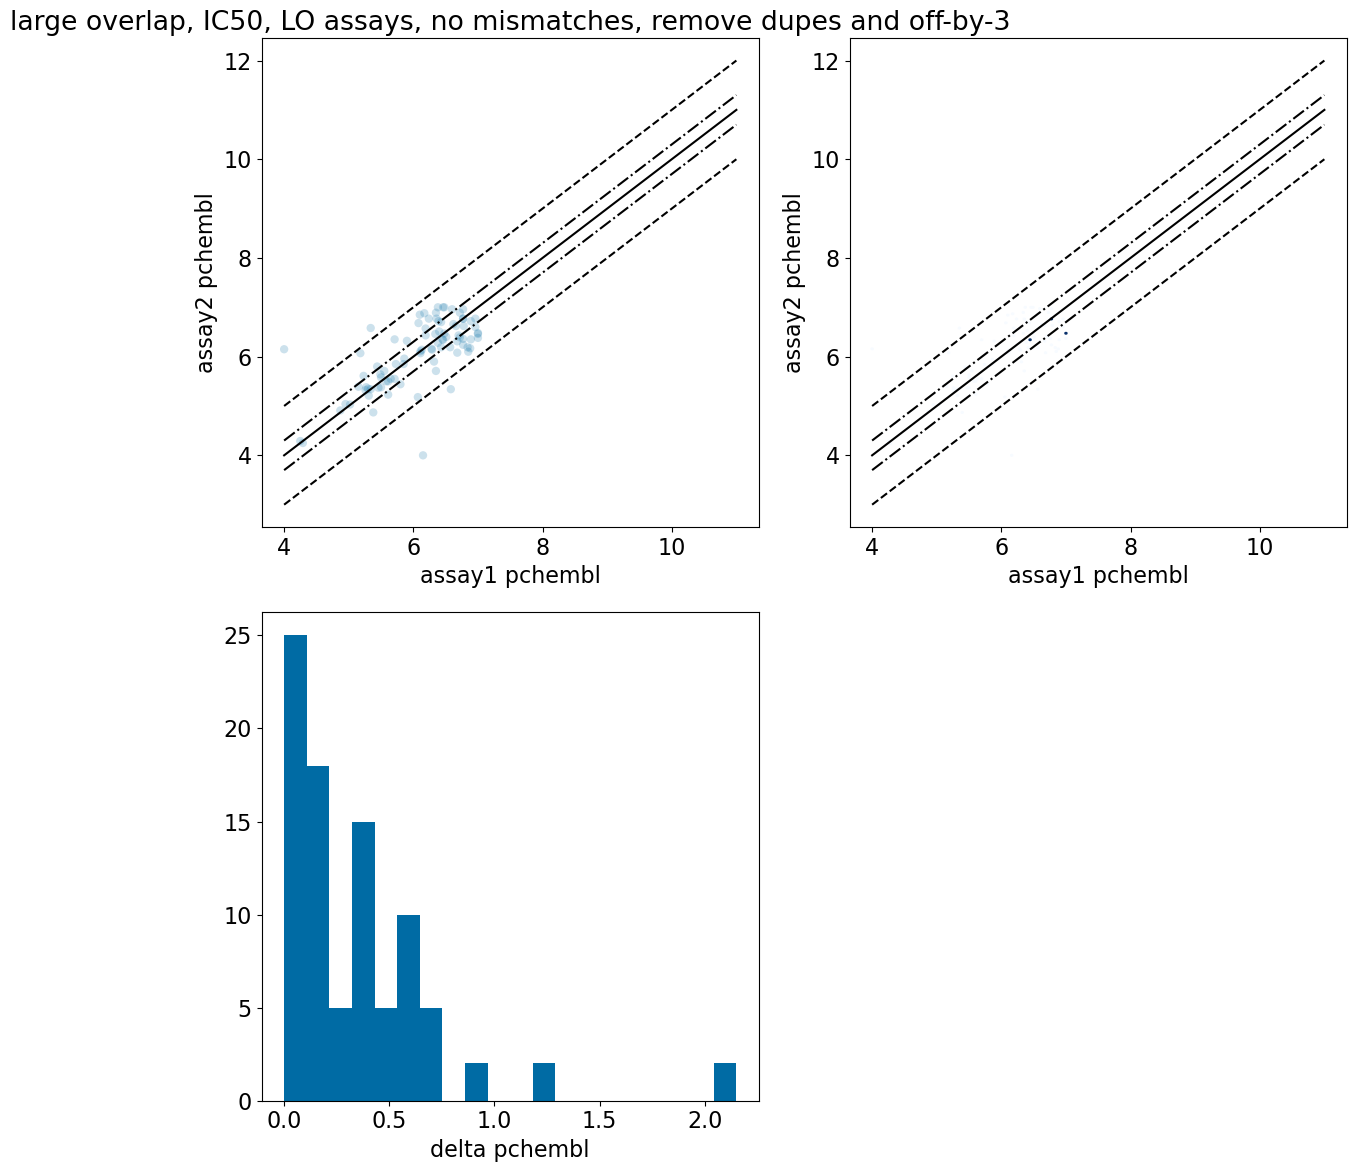

In [29]:
show_comparison(pts[tag],tag)

In [30]:
tag = 'large overlap, Ki, LO assays, no mismatches, remove dupes and off-by-3'
pts[tag] = gather_data('Ki',minOverlap=20)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 1 assay pairs
 * postgresql://ccg_read@scotland/chembl_32


1 assay pairs.
R2=-0.26, Spearman R=0.54 MAE=0.71
26 points. Fraction > 0.3: 0.81, fraction > 1.0: 0.38
Fraction with different classifications:
	 bin=5: 0.00, kappa=nan, balanced=1.00
	 [[26, 0], [0, 0]]
	 bin=6: 0.00, kappa=nan, balanced=1.00
	 [[26, 0], [0, 0]]
	 bin=7: 0.08, kappa=-0.06, balanced=0.48
	 [[22, 1], [3, 0]]
	 bin=8: 0.38, kappa=0.12, balanced=0.57
	 [[11, 1], [11, 3]]
	 bin=9: 0.35, kappa=0.19, balanced=0.60
	 [[5, 4], [6, 11]]


/localhome/glandrum/.conda/envs/py311_overlappingassays/lib/python3.11/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/localhome/glandrum/.conda/envs/py311_overlappingassays/lib/python3.11/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


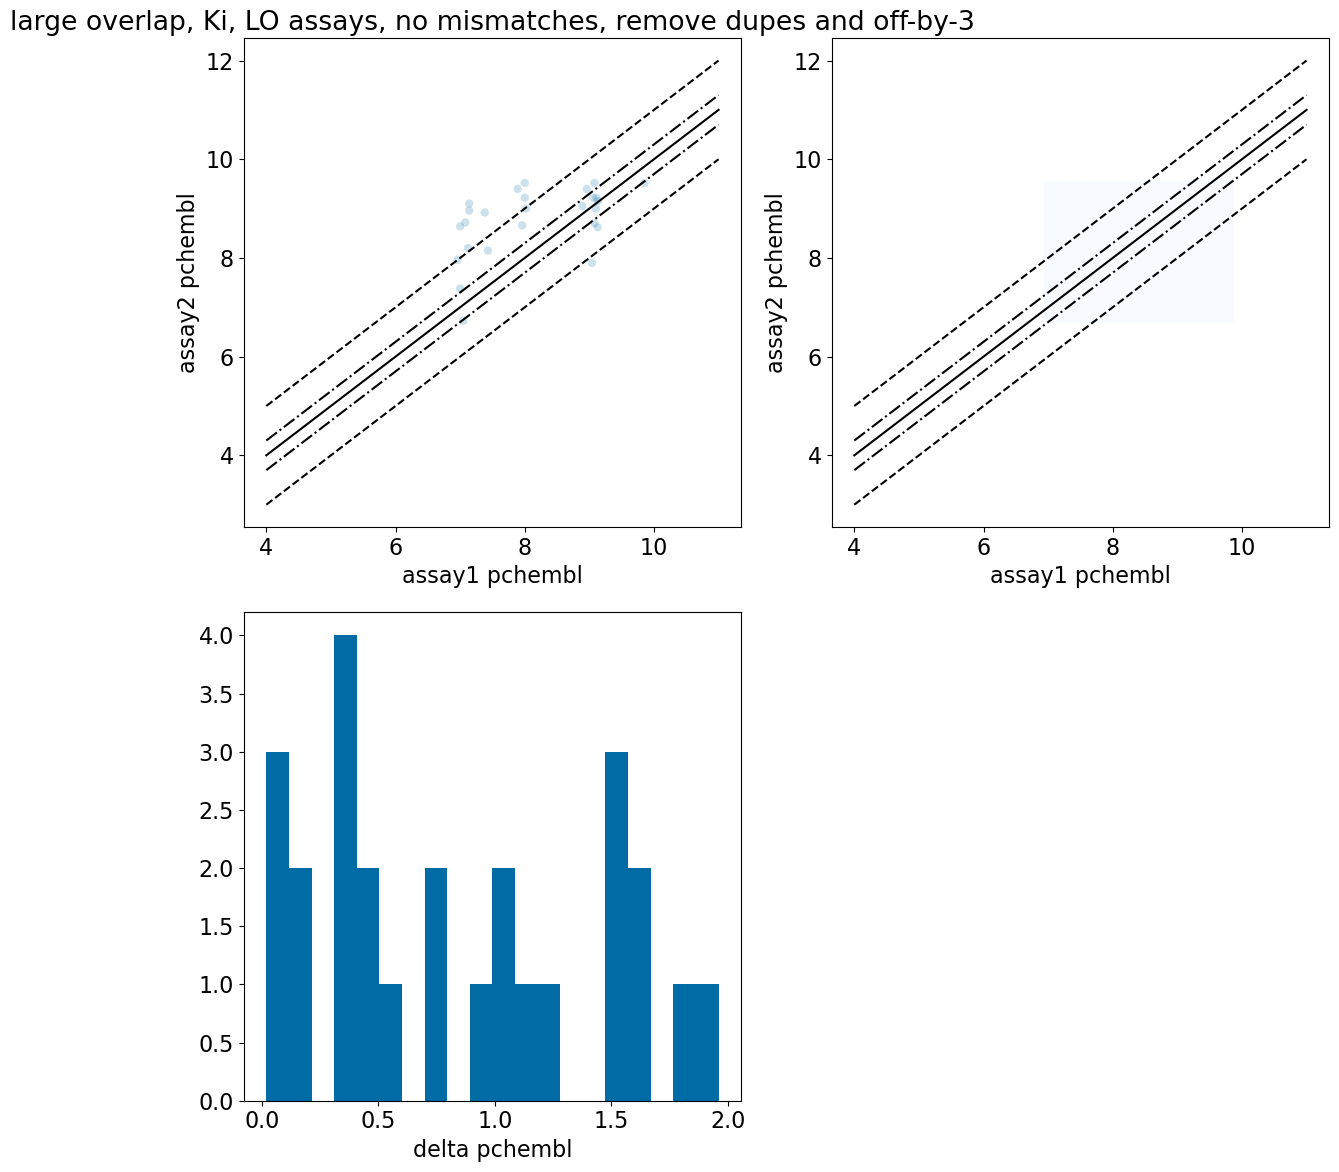

In [31]:
show_comparison(pts[tag],tag)